# Program for analysizing ISIMIP3b historical yields data

## Prepare packages and basic data

In [1]:
#!pip install statsmodels

In [1]:
import glob
import os
# Ignore warnings
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter('ignore')

#Process data
import pandas as pd
import numpy as np
import xarray as xr


In [2]:
#Display data 
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.vector_transform import vector_scalar_to_grid
from matplotlib.axes import Axes
import cartopy.feature as cfeature
from cartopy import config
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from mpl_toolkits.axes_grid1 import AxesGrid
import matplotlib.image as image
import matplotlib.pyplot as plt

In [3]:
import statsmodels.api as sm

In [4]:
# calculated area of each grid in unit square meter
areainsqmeter=np.load('originalcode/code/ipynb/areainsqmeter_squared_meter_great_lake_region_35N65N.npy')

#maize land use
## combined (irr + rainfed)
combined_landuse=np.load('originalcode/code/ipynb/combined_landuse_35N65N.npy')
## rainfed maize land use
rainfed_landuse=np.load('originalcode/code/ipynb/rainfed_landuse_35N65N.npy')
## irrigated maize land use
irrigated_landuse=np.load('originalcode/code/ipynb/irrigated_landuse_35N65N.npy')
# SPAM maize combined production 
spam_production=np.load('average_all.npy')
spam_production=np.where(spam_production <= 0, np.nan, spam_production) #remove grids with value <=0

In [5]:
np.nanpercentile(spam_production,1)

6.004332993825277

In [6]:
#data from https://www.pik-potsdam.de/~jonasjae/GGCMI_Phase3_grid_by_GCM_and_GGCM_1983_2099/
file='/media/Data1/Climada/isimip3/nc4/GGCMI_Phase3_annual_Maize_ssp126_gfdl-esm4_2015co2_ensemble_mean.nc4'
ds=xr.open_dataset(file,decode_times=False)

In [7]:
ds

<xarray.Dataset>
Dimensions:       (lon: 720, lat: 360, years: 117)
Coordinates:
  * lon           (lon) float64 -179.8 -179.2 -178.8 ... 178.8 179.2 179.8
  * lat           (lat) float64 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * years         (years) int32 1983 1984 1985 1986 1987 ... 2096 2097 2098 2099
Data variables:
    yield change  (years, lat, lon) float64 ...

In [8]:
#https://www.pik-potsdam.de/~jonasjae/GGCMI_Phase3_grid_by_GCM_and_GGCM_1901_2099/
file='/home/ziwang/Downloads/GGCMI_Phase3_annual_ssp126_gfdl-esm4_acea (1).nc4'
ds=xr.open_dataset(file,decode_times=False)
ds

<xarray.Dataset>
Dimensions:       (lon: 720, lat: 360, years: 199, crop: 4)
Coordinates:
  * lon           (lon) float64 -179.8 -179.2 -178.8 ... 178.8 179.2 179.8
  * lat           (lat) float64 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * years         (years) int32 1901 1902 1903 1904 1905 ... 2096 2097 2098 2099
  * crop          (crop) int32 1 2 3 4
Data variables:
    yield change  (crop, years, lat, lon) float64 ...

In [9]:
# data from  https://www.pik-potsdam.de/~jonasjae/GGCMI_Phase3_by_GCM_GGCM_mean/
file='/home/ziwang/Downloads/GGCMI_Phase3_annual_Maize_ssp126_gfdl-esm4_2015co2_ensemble_mean.nc4'
ds=xr.open_dataset(file,decode_times=False)
ds

<xarray.Dataset>
Dimensions:       (lon: 720, lat: 360, years: 117)
Coordinates:
  * lon           (lon) float64 -179.8 -179.2 -178.8 ... 178.8 179.2 179.8
  * lat           (lat) float64 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * years         (years) int32 1983 1984 1985 1986 1987 ... 2096 2097 2098 2099
Data variables:
    yield change  (years, lat, lon) float64 ...

## 1. test dataset

In [15]:
# define initial study region
min_lon = -100 
min_lat = 35
max_lon = -70
max_lat = 65

In [16]:
# set path of data 
Path='/media/Data1/Climada/isimip3/nc4/'
# climate models
gcms=['gfdl-esm4','ipsl-cm6a-lr','mpi-esm1-2-hr','mri-esm2-0','ukesm1-0-ll']
# crop models
ggcms=['acea','crover','cygma1p74','dssat-pythia','epic-iiasa',
       'ldndc','lpjml','pdssat','pepic','promet','simplace-lintul5','isam']


### Note: Jonas Jägermeyr's data reference period is 1983-2013 (31 years)

## Check the ratio of simulated production against observation from SPAM 

In [17]:
file='/media/Data1/Climada/ISIMIP3b/Data/acea_mri-esm2-0_w5e5_historical_2015soc_default_yield-mai-firr_global_annual-gs_1850_2014.nc'
ds=xr.open_dataset(file,decode_times=False)
ds

<xarray.Dataset>
Dimensions:         (lon: 720, lat: 360, time: 165)
Coordinates:
  * lon             (lon) float64 -179.8 -179.2 -178.8 ... 178.8 179.2 179.8
  * lat             (lat) float64 89.75 89.25 88.75 ... -88.75 -89.25 -89.75
  * time            (time) float64 249.0 250.0 251.0 252.0 ... 411.0 412.0 413.0
Data variables:
    yield-mai-firr  (time, lat, lon) float32 ...
Attributes:
    title:                    ACEA simulations for Ag-GRID GGCMI Phase 3 project
    institution:              University of Twente, Netherlands
    contact:                  Oleks Mialyk o.mialyk@utwente.nl
    isimip_id:                7e9853ed-f08b-46d7-8245-59a50e101a7d
    isimip_protocol_version:  b57c1cb304874b20c114a66b7f8c39d9259863ab
    isimip_qc_pass_date:      2021-09-24 09:03 UTC
    isimip_qc_version:        2.7.0

In [18]:
#check if all data are available
# define an array to store percentiles 25th, 50th and 75th 5th and 95th percentiles
prod60X60=np.full((60, 60, 12,5), np.nan)  #X, Y, ggcm,gcm 
ratio60X60=np.full((60, 60, 60), np.nan)  #X, Y, Simulations 
ptl=np.full((60, 5), np.nan) 
ptl50=np.full((12,5),np.nan) #save median as 12X5 array 
ij=0
ii=0

for ggcm in ggcms:  #crop models
    jj=0
    for gcm in gcms:   #climate models
        s1="/media/Data1/Climada/ISIMIP3b/Data/"
        s2=ggcm+'_'+gcm
        s3='_w5e5_historical_2015soc_default_yield-mai-*.nc'  #maize yield data files
        s4=s1+s2+'_w5e5_historical_2015soc_default_yield-mai-firr*.nc'    #irrigated
        s5=s1+s2+'_w5e5_historical_2015soc_default_yield-mai-noirr*.nc'   #rainfed
        ss=s1+s2+s3  #maize yield files, to check if there are 2 files
        fns=glob.glob(ss)
        if len(fns)<2:  
            print(ggcm+' '+gcm+' '+str(len(fns)))
            continue
        else:
            #irrigated
            fns1=glob.glob(s4)
            if ij==0 and ii==0:
                print(fns1[0])
            file1=fns1[0]   #irrigated file
            ds=xr.open_dataset(file1,decode_times=False)
            # substract data for the last 19 years, 1995 to 2014
            cropped_ds = ds.sel(lat=slice(max_lat,min_lat), lon=slice(min_lon,max_lon), time=slice(394,413))
                #average over years rainfed
            crop_isimip3b1_mean=cropped_ds.mean(dim='time')*irrigated_landuse/100
            
            #rainfed maize file
            fns2=glob.glob(s5)
            #print(fns2[0])
            file1=fns2[0]
            ds=xr.open_dataset(file1,decode_times=False)
            cropped_ds = ds.sel(lat=slice(max_lat,min_lat), lon=slice(min_lon,max_lon), time=slice(394,413))
                #average over years and sum over rainfed
            crop_isimip3b2_mean=cropped_ds.mean(dim='time')*rainfed_landuse/100  #average over time and landuse (%)         
            # combined yield for each grid
            crop_isimip3b_mean= crop_isimip3b1_mean['yield-mai-firr'].fillna(0) \
                                +crop_isimip3b2_mean['yield-mai-noirr'].fillna(0)
            #production on each grid: 1ha = 10000 m^2
            prod=crop_isimip3b_mean*areainsqmeter/10000
            
            #check the ratio rather than absolute production
            ratio=prod/spam_production
            prod60X60[:,:,ii,jj]=prod
            ratio60X60[:,:,ij]=ratio
            d1=np.array(ratio).ravel()


            d2=d1[~np.isnan(d1)]  #remove grid without maize
            d2=d2[d2>0]   #remove grid with production<=0
            percentile_75 = np.percentile(d2, 75)   #75th percentiles
            percentile_25 = np.percentile(d2, 25)   #25th percentiles
            percentile_50 = np.percentile(d2, 50)   #50th percentiles or mediean values         
            d95=np.nanpercentile(d2, 95)  #95th percentile
            d05=np.nanpercentile(d2, 5)   #5th percentile
            d3=d2[d2<d95]   #remove extreme high values
            d3=d3[d3>d05]   #remove extreme low values

            ptl[ij,:]=[percentile_25,percentile_50,percentile_75, d05,d95]  #save 25th, 50th and 75th percentiles
            print(len(d2),[d05,percentile_25,percentile_50,percentile_75,d95],len(d3)) #display results
            ptl50[ii,jj]=percentile_50
            ij=ij+1
        jj=jj+1
    ii=ii+1
np.save('isimip3b_production_60X60X12ggcmsX5gcms.npy',prod60X60)            

acea gfdl-esm4 0
acea ipsl-cm6a-lr 0
acea mpi-esm1-2-hr 0
/media/Data1/Climada/ISIMIP3b/Data/acea_mri-esm2-0_w5e5_historical_2015soc_default_yield-mai-firr_global_annual-gs_1850_2014.nc
1261 [0.6270288123533158, 1.0902970628259614, 1.7833565397477114, 4.373717572038798, 31.193971214200882] 1133
1261 [0.6006856109037638, 1.043819008395248, 1.7491676017396698, 4.251488325857521, 28.849816173701203] 1133
1219 [0.3273779481416216, 0.5259630576293859, 0.8607045423327113, 1.948837930755471, 14.004875950766802] 1097
1219 [0.3306772454234783, 0.5288708272599347, 0.8744615178409542, 1.9754186951446115, 13.974402738272435] 1097
1219 [0.31823167831246235, 0.5355397834427407, 0.8764236542372895, 1.9973364668315159, 13.97304200707483] 1097
1219 [0.3279252544827907, 0.5357329313093252, 0.8849603942597509, 2.0093011849371845, 14.264945109248089] 1097
1219 [0.31543225625203875, 0.5187606142823968, 0.8535037376285612, 1.9362676570150974, 13.532227023165337] 1097
1261 [0.46209233094045343, 0.77512491928

In [9]:
ratio.shape

(60, 60)

In [10]:
np.nanmean(prod60X60,3).shape

(60, 60, 12)

### Different ggcms

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.898
Model:                            OLS   Adj. R-squared:                  0.898
Method:                 Least Squares   F-statistic:                 1.116e+04
Date:                Tue, 05 Mar 2024   Prob (F-statistic):               0.00
Time:                        16:46:41   Log-Likelihood:                -15738.
No. Observations:                1263   AIC:                         3.148e+04
Df Residuals:                    1261   BIC:                         3.149e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.872e+04   2132.122     18.162      0.0

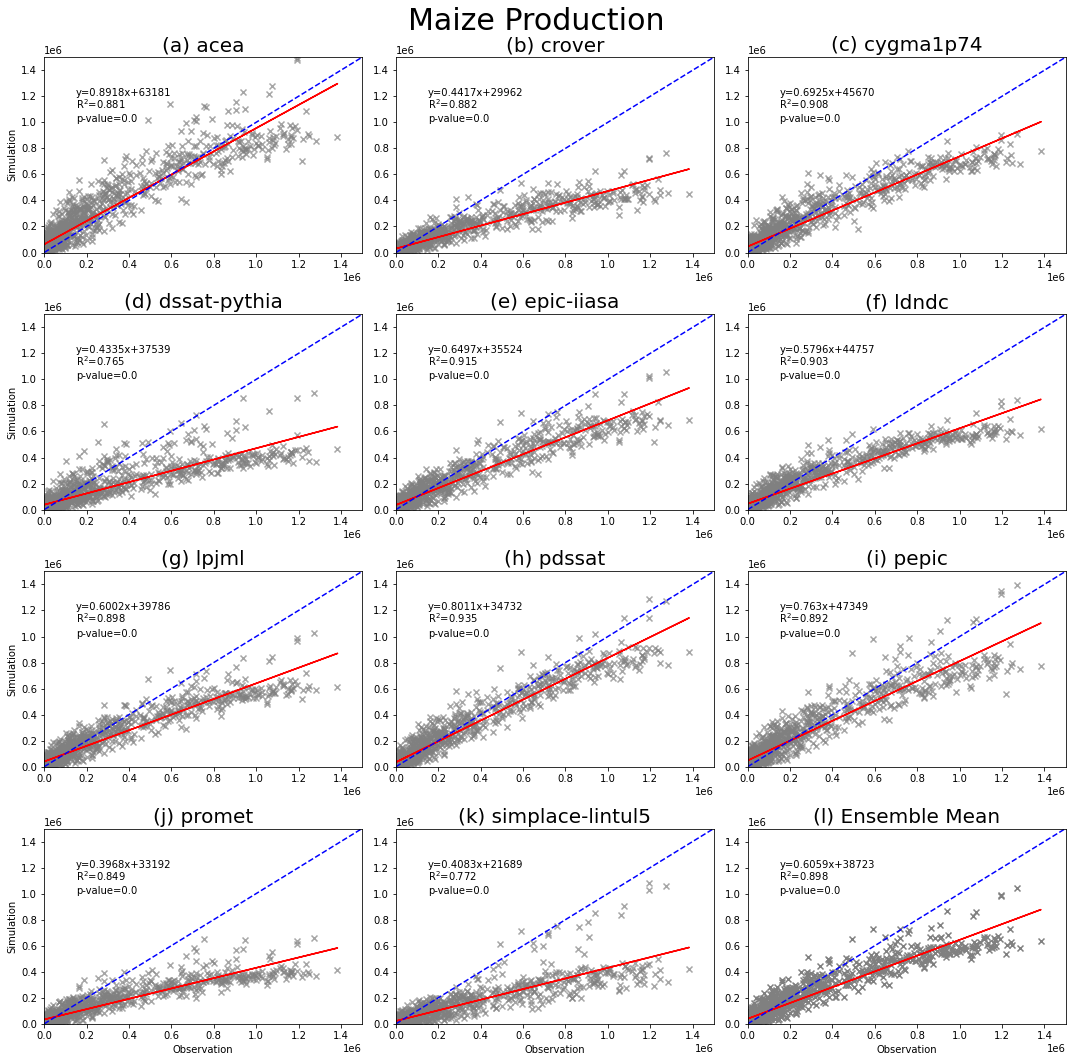

In [11]:
name_ggcms=['(a) acea','(b) crover','(c) cygma1p74','(d) dssat-pythia','(e) epic-iiasa',
       '(f) ldndc','(g) lpjml','(h) pdssat','(i) pepic','(j) promet','(k) simplace-lintul5','(l) Ensemble']
fig, axes = plt.subplots(4, 3, figsize=(15, 15))
axes = axes.flatten()
ii=0
mp1=np.nanmean(prod60X60,axis=3)
for iggcm in range(11):

    data=mp1[:,:,iggcm]
        
    X = spam_production.ravel()
    Y = data.ravel()
    X[X<=0]=np.nan
    Y[Y<=0]=np.nan
    mask = [~np.isnan(X) & ~np.isnan(Y)] 
    X=X[mask]
    Y=Y[mask]
    if len(X)==0:
        ii=ii+1
        continue
        
    # Add a constant term to the independent variable for intercept estimation
    X_with_const = sm.add_constant(X)

    # Fit the linear regression model
    model = sm.OLS(Y, X_with_const)
    results = model.fit()

    # Print the summary
    #print(results.summary())    
    coefficients1 = np.polyfit(X, Y, 1)
    regression_line1 = np.polyval(coefficients1, X)
    
    ax=axes[ii]
    ax.scatter(X,Y,color='grey', marker='x',alpha=0.7,  label='Data Points') 
    ax.plot(X, regression_line1, color='red')
    ax.text(150000,1200000, 'y='+str(round(coefficients1[0],4))+'x+'+str(int(coefficients1[1])))
    x_values = np.linspace(0, 1500000, 1000000)

    # Plot the dashed line y = x
    ax.plot(x_values, x_values, linestyle='--', color='blue', label='y = x')
    ax.text(150000,1100000, 'R$^2$='+str(round(results.rsquared,3)))
    ax.text(150000,1000000, 'p-value='+str(round(results.pvalues[1],3)))
    if (ii>8):
        ax.set_xlabel('Observation')
    if (ii==0 or ii==3 or ii==6 or ii==9):
        ax.set_ylabel('Simulation')
    plt.suptitle('Maize Production',fontsize=30)
    ax.set_title(name_ggcms[ii], fontsize=20)
    ax.set_xlim([0,1500000])
    ax.set_ylim([0,1500000])

#     ax.set_xlim(0,15)
#     ax.set_ylim(0,15)    
    ii=ii+1
data=np.nanmean(np.nanmean(prod60X60,axis=3),axis=2)
# #/spam_production
X = spam_production.ravel()
Y=data.ravel()
X[X<=0]=np.nan
Y[Y<=0]=np.nan
mask = ~np.isnan(X) & ~np.isnan(Y) 
X=X[mask]
Y=Y[mask]
# Add a constant term to the independent variable for intercept estimation
X_with_const = sm.add_constant(X)

# Fit the linear regression model
model = sm.OLS(Y, X_with_const)
results = model.fit()

# Print the summary
print(results.summary())
coefficients1 = np.polyfit(X, Y, 1)
regression_line1 = np.polyval(coefficients1, X)
    
ax=axes[ii]
ax.scatter(X,Y,color='grey', marker='x', label='Data Points') 
ax.plot(X, regression_line1, color='red')
x_values = np.linspace(0, 1500000, 1000000)

# Plot the dashed line y = x
ax.plot(x_values, x_values, linestyle='--', color='blue', label='y = x')
ax.text(150000,1200000, 'y='+str(round(coefficients1[0],4))+'x+'+str(int(coefficients1[1])))
ax.text(150000,1100000, 'R$^2$='+str(round(results.rsquared,3)))
ax.text(150000,1000000, 'p-value='+str(round(results.pvalues[1],3)))
ax.set_xlim([0,1500000])
ax.set_ylim([0,1500000])
plt.xlabel('Observation')
#plt.ylabel('Simulation')
plt.suptitle('Maize Production', fontsize=30)
ax.set_title("(l) Ensemble Mean", fontsize=20)

plt.tight_layout()
fig.savefig('isimip3b_historical_production_observation_simulation_regression_for_maize_ggcms.png',dpi=150)

In [12]:
print([np.nansum(X),np.nansum(Y),np.nansum(Y)-np.nansum(X), np.nansum(Y)/np.nansum(X),np.nansum(Y)/np.nansum(X)-1])

[265706988.17349368, 209907619.97860396, -55799368.194889724, 0.7899966102568011, -0.21000338974319888]


## The global gridded crop models (GGCMs) exhibit a consistent trend of simulating maize production lower than observed levels, driven by the simulated climate conditions. Over a 19-year average in the study region, the simulated production consistently lags behind the observed by 21%. In the specific year 2000, the deficit is slightly lower at 7%, but in 2005, it increases significantly to 20.6%. The most substantial deviation occurs in 2010, where the simulated production is 29.3% less than the observed, emphasizing the notable disparities in simulation outcomes across different years and the overall underestimation of maize production by the GGCMs in this particular region.

[692626.9825982846, 67.81408180339953]
[735519.0517697781, 348.7140286062826]
[208001.92168871354, 260532.0523551433]


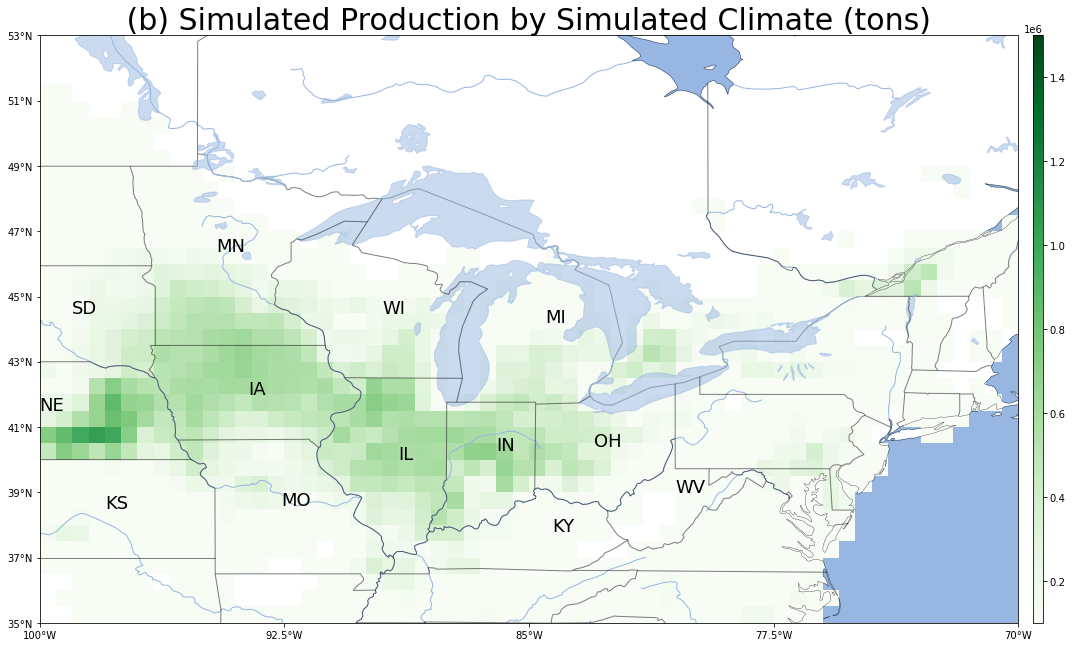

In [23]:
#Display data 
fn='/media/Data1/Climada/isimip3/maize3a/GGCMI_Phase3a_simplace-lintul5_gswp3-w5e5_default_annual_mai_yield_and_production.nc4'
ds=xr.open_dataset(fn,decode_times=False)
cropped_ds1 = ds.sel(lat=slice(max_lat,min_lat), lon=slice(min_lon,max_lon),years=slice('1995','2014'), irr=1.0).fillna(0)
cropped_ds2 = ds.sel(lat=slice(max_lat,min_lat), lon=slice(min_lon,max_lon),years=slice('1995','2014'), irr=2.0).fillna(0)

#average over years and sum over irrigated and rainfed
crop_isimip3a1_mean=cropped_ds1.mean(dim='years')*rainfed_landuse/100
crop_isimip3a2_mean=cropped_ds2.mean(dim='years')*irrigated_landuse/100
crop_isimip3a_mean= crop_isimip3a1_mean+crop_isimip3a2_mean
#mask=np.load('/media/Data1/Climada/isimip3/reference/maize_combined_observational_mask.npy')
mask=np.load('/media/Data1/Climada/isimip3/reference/isimip3b_mask60X60.npy')
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.vector_transform import vector_scalar_to_grid
from matplotlib.axes import Axes
import cartopy.feature as cfeature
from cartopy import config
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from mpl_toolkits.axes_grid1 import AxesGrid
import matplotlib.image as image
import matplotlib.pyplot as plt

provinces= ['Ontario', 'Quebec','Manitoba','Wisconsin','Vermont','Nebraska','New York','Kansas','Illinois',
            'Delaware','Connecticut','Indiana','Missouri','Michigan','New Jersey','Kentucky','Minnesota',
            'Ohio','Iowa','Pennsylvania','Maryland','Virginia','West Virginia','North Dakota','South Dakota','Nunavut']
provinces1=['ON','QC','MB','WI','VT','NE','NY','KS','IL','DE','CT','IN','MO','MI','NJ','KY','MN','OH','IA','PA','MD','VA','WV','ND','SD','NU']
Latitudes= [50,53,56.4,44.5,44,41.5,43,38.5,40,39,41.6,40.3,38.6,44.2,39.8,37.8,46.4,
            40.4,42,41.2,39,38,39,47.7,44.5,62]
Longitudes=[-85,-76,-98.7,-89.5,-72,-100,-75,-98,-89,-73.5,-72.7,-86,-92.6,-84.5,-74.9,-84.3,-94.6,
            -83,-93.6,-77.2,-76.6,-78,-80.5,-99,-99,-98]

lats = crop_isimip3a_mean.coords['lat'][:]
lons = crop_isimip3a_mean.coords['lon'][:]
X,Y = np.meshgrid(lons,lats)
projection = ccrs.PlateCarree()
provinc_bodr = cartopy.feature.NaturalEarthFeature(category='cultural',
    name='admin_1_states_provinces_lines', scale='50m', facecolor='none', edgecolor='k')
axes_class = (GeoAxes,
              dict(map_projection=projection))
# lons, lats = np.meshgrid(lons, lats)
title_text=["Refereance", "2050s", "2080s"]
fig = plt.figure(figsize=(15,15))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(1, 1),
                axes_pad=0.6,
                cbar_location='right',
                cbar_mode='single',
                cbar_pad=0.2,
                cbar_size='1%',
                label_mode='')  # note the empty labe
for i, ax in enumerate(axgr):
#*************************************************************
    if i==0:
        data=np.nanmean(np.nanmean(prod60X60,axis=3),axis=2)
        data=np.where(data == 0, np.nan, data)
        data=data*mask
#         mask=np.where(data >=0,1,data)
        subtitle=" (b) Simulated Production by Simulated Climate (tons) "
        print([np.nanpercentile(data,99.0),np.nanpercentile(data,0)])
        print([np.nanpercentile(data[37:56,:40],99.0),np.nanpercentile(data[37:56,:40],0)])
        print([np.nanpercentile(data[37:56,:40],50.0),np.nanmean(data[37:56,:40])])          
  
                     
#add ocean, coastline,borders,lakes,rivers,provinc_bodr
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE,linewidth=0.3)
    ax.add_feature(cfeature.BORDERS, linestyle='-', alpha=0.5)
    ax.add_feature(cfeature.LAKES, alpha=0.5)
    ax.add_feature(cfeature.RIVERS)
    ax.add_feature(provinc_bodr, linestyle='-', linewidth=1, edgecolor="k", zorder=10, alpha=0.5)
    ax.set_title(subtitle, fontsize=30)
    ax.set_xlim([-100,-70])
    ax.set_ylim([35,53])
    ax.set_xticks(np.linspace(-100, -70, 5), crs=projection)
    ax.set_yticks(np.linspace(35, 53, 10), crs=projection)
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    
#     p = ax.contourf(lons, lats, data,50,
#                         transform=projection,
#                         cmap='BrBG')
    
#     l = ax.contour(lons, lats, data,25,colors=['black'], linewidth=0.3,
#                         transform=ccrs.PlateCarree())
    for iprov in range(26):
        if Longitudes[iprov]<-80 and Latitudes[iprov]<47:
            ax.text(Longitudes[iprov],Latitudes[iprov],provinces1[iprov],fontsize=18)
#     p = ax.pcolormesh(X, Y, data,
#                       vmin=-300,
#                       vmax=300,
#                       transform=projection,
#                       cmap='Reds')
    p = ax.pcolormesh(X, Y, data,
                      transform=projection,
                      vmin=100000,
                      vmax=1500000,
                      cmap='Greens')    
#     ax.clabel(
#         l,  # Typically best results when labelling line contours.
#         colors=['black'],
#         manual=False,  # Automatic placement vs manual placement.
#         inline=True,  # Cut the line where the label will be placed.
#         fmt=' {:.0f} '.format,  # Labes as integers, with some extra space.
#     )
axgr.cbar_axes[0].colorbar(p)
plt.tight_layout()
plt.show()
fig.savefig('isimip3b_production_for_maize_20Years.png',dpi=150)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.898
Model:                            OLS   Adj. R-squared:                  0.898
Method:                 Least Squares   F-statistic:                 1.116e+04
Date:                Fri, 23 Feb 2024   Prob (F-statistic):               0.00
Time:                        15:55:58   Log-Likelihood:                -15738.
No. Observations:                1263   AIC:                         3.148e+04
Df Residuals:                    1261   BIC:                         3.149e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.872e+04   2132.122     18.162      0.0

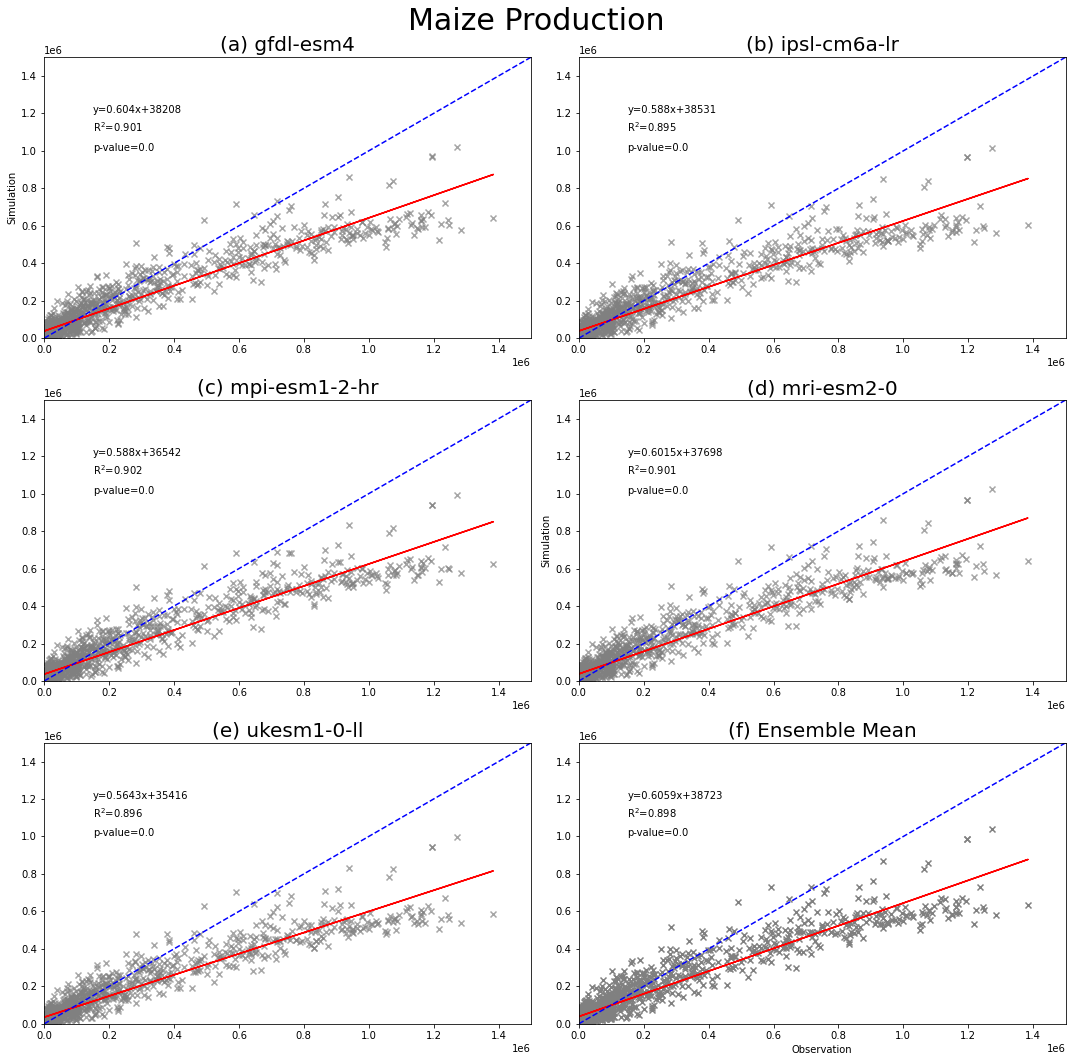

In [27]:
name_gcms=['(a) gfdl-esm4','(b) ipsl-cm6a-lr','(c) mpi-esm1-2-hr','(d) mri-esm2-0','(e) ukesm1-0-ll']
fig, axes = plt.subplots(3, 2, figsize=(15, 15))
axes = axes.flatten()
ii=0
mp1=np.nanmean(prod60X60,axis=2)
for igcm in range(5):

    data=mp1[:,:,igcm]
        
    X = spam_production.ravel()
    Y = data.ravel()
    X[X<=0]=np.nan
    Y[Y<=0]=np.nan
    mask = [~np.isnan(X) & ~np.isnan(Y)] 
    X=X[mask]
    Y=Y[mask]
    if len(X)==0:
        ii=ii+1
        continue
    # Add a constant term to the independent variable for intercept estimation
    X_with_const = sm.add_constant(X)

    # Fit the linear regression model
    model = sm.OLS(Y, X_with_const)
    results = model.fit()

    # Print the summary
    #print(results.summary())            
    coefficients1 = np.polyfit(X, Y, 1)
    regression_line1 = np.polyval(coefficients1, X)
    
    ax=axes[ii]
    ax.scatter(X,Y,color='grey', marker='x',alpha=0.7,  label='Data Points') 
    ax.plot(X, regression_line1, color='red')
    ax.text(150000,1200000, 'y='+str(round(coefficients1[0],4))+'x+'+str(int(coefficients1[1])))
    ax.text(150000,1100000, 'R$^2$='+str(round(results.rsquared,3)))
    ax.text(150000,1000000, 'p-value='+str(round(results.pvalues[1],3)))
    ax.set_xlim([0,1500000])
    ax.set_ylim([0,1500000])
    x_values = np.linspace(0, 1500000, 1000000)

    # Plot the dashed line y = x
    ax.plot(x_values, x_values, linestyle='--', color='blue', label='y = x')    
    if (ii>8):
        ax.set_xlabel('Observation')
    if (ii==0 or ii==3 or ii==6 or ii==9):
        ax.set_ylabel('Simulation')
    plt.title('Production')
    ax.set_title(name_gcms[ii], fontsize=20)

#     ax.set_xlim(0,15)
#     ax.set_ylim(0,15)    
    ii=ii+1
data=np.nanmean(np.nanmean(prod60X60,axis=3),axis=2)
# #/spam_production
X = spam_production.ravel()
Y=data.ravel()
X[X<=0]=np.nan
Y[Y<=0]=np.nan
mask = ~np.isnan(X) & ~np.isnan(Y) 
X=X[mask]
Y=Y[mask]
# Add a constant term to the independent variable for intercept estimation
X_with_const = sm.add_constant(X)
# Fit the linear regression model
model = sm.OLS(Y, X_with_const)
results = model.fit()
# Print the summary
print(results.summary())  

coefficients1 = np.polyfit(X, Y, 1)
regression_line1 = np.polyval(coefficients1, X)
    
ax=axes[ii]
ax.scatter(X,Y,color='grey', marker='x', label='Data Points') 
ax.plot(X, regression_line1, color='red')
ax.text(150000,1200000, 'y='+str(round(coefficients1[0],4))+'x+'+str(int(coefficients1[1])))
ax.text(150000,1100000, 'R$^2$='+str(round(results.rsquared,3)))
ax.text(150000,1000000, 'p-value='+str(round(results.pvalues[1],3)))
ax.set_xlim([0,1500000])
ax.set_ylim([0,1500000])
x_values = np.linspace(0, 1500000, 1000000)

# Plot the dashed line y = x
ax.plot(x_values, x_values, linestyle='--', color='blue', label='y = x')
plt.xlabel('Observation')
#plt.ylabel('Simulation')
plt.suptitle('Maize Production', fontsize=30)
ax.set_title("(f) Ensemble Mean", fontsize=20)
plt.tight_layout()
fig.savefig('isimip3b_historical_production_observation_simulation_regression_for_maize_gcms.png',dpi=150)

### figure caption:
Figure X: Comparison of observed and simulated maize production across multiple climate models.

Each subfigure (a)-(f) presents a scatter plot overlaid with a red regression line, illustrating the relationship between observed maize production (averaged for the years 2000, 2005, and 2010 using SPAM data) and simulated production. The x-axis represents the observed maize production, while the y-axis depicts the ensemble mean of simulated production averaged over the 19-year period from 1996 to 2014, generated by 11 GGCMs.

Each data point within the scatter plots corresponds to a grid cell within the study area where maize production occurs, providing spatial insights into the comparison between observed and simulated values.

The subtitle of each subfigure denotes the specific GCM used for simulation, capturing the variability across different climate models. The final subfigure (f) showcases the ensemble mean over the 5 GCMs, offering a synthesized perspective on the agreement between observed and simulated maize production across a subset of GCMs.

These scatter plots offer valuable insights into the performance of multiple GCMs in reproducing observed maize production patterns, contributing to our understanding of the reliability and variability of climate model simulations in the context of agricultural outcomes.

### summary
The scatter plots comparing observed and simulated maize production across multiple climate models for the period 1996-2016 reveal several key findings. Despite being driven by climate data from General Circulation Models (GCMs), the simulated maize production remains significantly correlated with observed production. However, compared to simulations driven by real climate data, the GCM-driven simulated production consistently exhibits lower levels, as evidenced by considerably lower regression coefficients (ranging from 0.56 to 0.60) and deviations of the regression line from the diagonal line (y=x). The ensemble mean regression coefficient is 0.6, notably lower than the 0.82 observed in simulations driven by real climate data. Despite these discrepancies, the regressions remain statistically significant, supported by high R-squared values and near-zero p-values. These findings suggest that while simulations driven by GCM climate data may underestimate maize production compared to real climate-driven simulations, they still provide valuable insights and maintain statistical significance for understanding the relationship between climate and maize production.


## for single year 2000

In [28]:
prod2000_60x60=np.load('/media/Data1/Climada/isimip3/originalcode/code/ipynb/prod2000_60x60.npy')
prod2005_60x60=np.load('/media/Data1/Climada/isimip3/originalcode/code/ipynb/prod2005_60x60.npy')
prod2010_60x60=np.load('/media/Data1/Climada/isimip3/originalcode/code/ipynb/prod2010_60x60.npy')

irrigated_maize_prod2000_60x60=np.load('/media/Data1/Climada/isimip3/originalcode/code/ipynb/irrigated_maize_prod2000_60x60.npy')
irrigated_maize_prod2005_60x60=np.load('/media/Data1/Climada/isimip3/originalcode/code/ipynb/irrigated_maize_prod2005_60x60.npy')
irrigated_maize_prod2010_60x60=np.load('/media/Data1/Climada/isimip3/originalcode/code/ipynb/irrigated_maize_prod2010_60x60.npy')

# convert nan to 0
prod2000_60x60=np.nan_to_num(prod2000_60x60)
prod2005_60x60=np.nan_to_num(prod2005_60x60)
prod2010_60x60=np.nan_to_num(prod2010_60x60)
irrigated_maize_prod2000_60x60[irrigated_maize_prod2000_60x60<0]=0
irrigated_maize_prod2005_60x60[irrigated_maize_prod2005_60x60<0]=0
irrigated_maize_prod2010_60x60[irrigated_maize_prod2010_60x60<0]=0
#important: without this step, all nan will transfer to all
irrigated_maize_prod2000_60x60=np.nan_to_num(irrigated_maize_prod2000_60x60)
irrigated_maize_prod2005_60x60=np.nan_to_num(irrigated_maize_prod2005_60x60)
irrigated_maize_prod2010_60x60=np.nan_to_num(irrigated_maize_prod2010_60x60)
# calculate 3-year averages
all_prod2000_60x60=prod2000_60x60+irrigated_maize_prod2000_60x60
all_prod2005_60x60=prod2005_60x60+irrigated_maize_prod2005_60x60
all_prod2010_60x60=prod2010_60x60+irrigated_maize_prod2010_60x60

In [29]:
#check if all data are available
# define an array to store percentiles 25th, 50th and 75th 5th and 95th percentiles
prod60X60=np.full((60, 60, 12,5), np.nan)  #X, Y, ggcm,gcm 
ratio60X60=np.full((60, 60, 60), np.nan)  #X, Y, Simulations 
ptl=np.full((60, 5), np.nan) 
ptl50=np.full((12,5),np.nan) #save median as 12X5 array 
ij=0
ii=0

for ggcm in ggcms:  #crop models
    jj=0
    for gcm in gcms:   #climate models
        s1="/media/Data1/Climada/ISIMIP3b/Data/"
        s2=ggcm+'_'+gcm
        s3='_w5e5_historical_2015soc_default_yield-mai-*.nc'  #maize yield data files
        s4=s1+s2+'_w5e5_historical_2015soc_default_yield-mai-firr*.nc'    #irrigated
        s5=s1+s2+'_w5e5_historical_2015soc_default_yield-mai-noirr*.nc'   #rainfed
        ss=s1+s2+s3  #maize yield files, to check if there are 2 files
        fns=glob.glob(ss)
        if len(fns)<2:  
            print(ggcm+' '+gcm+' '+str(len(fns)))
            continue
        else:
            #irrigated
            fns1=glob.glob(s4)
            #print(fns1[0])
            file1=fns1[0]   #irrigated file
            ds=xr.open_dataset(file1,decode_times=False)
            # substract data for the last 19 years, 1996 to 2014
            cropped_ds = ds.sel(lat=slice(max_lat,min_lat), lon=slice(min_lon,max_lon), time=slice(399,399))
                #average over years rainfed
            crop_isimip3b1_mean=cropped_ds.mean(dim='time')*irrigated_landuse/100
            
            #rainfed maize file
            fns2=glob.glob(s5)
            #print(fns2[0])
            file1=fns2[0]
            ds=xr.open_dataset(file1,decode_times=False)
            cropped_ds = ds.sel(lat=slice(max_lat,min_lat), lon=slice(min_lon,max_lon), time=slice(399,399))
                #average over years and sum over rainfed
            crop_isimip3b2_mean=cropped_ds.mean(dim='time')*rainfed_landuse/100  #average over time and landuse (%)         
            # combined yield for each grid
            crop_isimip3b_mean= crop_isimip3b1_mean['yield-mai-firr'].fillna(0) \
                                +crop_isimip3b2_mean['yield-mai-noirr'].fillna(0)
            #production on each grid: 1ha = 10000 m^2
            prod=crop_isimip3b_mean*areainsqmeter/10000
            
            #check the ratio rather than absolute production
            ratio=prod/spam_production
            prod60X60[:,:,ii,jj]=prod
            ratio60X60[:,:,ij]=ratio
            d1=np.array(ratio).ravel()


            d2=d1[~np.isnan(d1)]  #remove grid without maize
            d2=d2[d2>0]   #remove grid with production<=0
            percentile_75 = np.percentile(d2, 75)   #75th percentiles
            percentile_25 = np.percentile(d2, 25)   #25th percentiles
            percentile_50 = np.percentile(d2, 50)   #50th percentiles or mediean values         
            d95=np.nanpercentile(d2, 95)  #95th percentile
            d05=np.nanpercentile(d2, 5)   #5th percentile
            d3=d2[d2<d95]   #remove extreme high values
            d3=d3[d3>d05]   #remove extreme low values

            ptl[ij,:]=[percentile_25,percentile_50,percentile_75, d05,d95]  #save 25th, 50th and 75th percentiles
            print(len(d2),[d05,percentile_25,percentile_50,percentile_75,d95],len(d3)) #display results
            ptl50[ii,jj]=percentile_50
            ij=ij+1
        jj=jj+1
    ii=ii+1
            

acea gfdl-esm4 0
acea ipsl-cm6a-lr 0
acea mpi-esm1-2-hr 0
1259 [0.6113632100383986, 1.175602195729364, 1.89558994046843, 4.477488156724987, 31.073523287556206] 1133
1261 [0.5786329244203066, 0.9989767371917041, 1.719298049906929, 4.125385185187126, 29.69195936694202] 1133
1215 [0.319425516881403, 0.5522331074152977, 0.9330023085886401, 2.0857303637570457, 15.866897776140902] 1093
1219 [0.38174985801045397, 0.6027566881840825, 0.9708816216857757, 2.0857646938346908, 15.387288159246] 1097
1219 [0.38064940149345955, 0.597776657813758, 0.9799573470649612, 2.125279529269512, 16.132309025637436] 1097
1219 [0.32189279001311755, 0.5517165400948109, 0.895938874479678, 1.9792205271751335, 13.8768806576784] 1097
1219 [0.3431986886332446, 0.5203038966534453, 0.8682700663948516, 1.931179172300035, 14.856042359648233] 1097
1261 [0.4933123102482499, 0.7719801917693433, 1.36530265146956, 3.304850177843318, 26.567354313051514] 1133
1261 [0.6011177020164353, 0.9449000655437184, 1.5199025854715014, 3.339

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.898
Model:                            OLS   Adj. R-squared:                  0.898
Method:                 Least Squares   F-statistic:                 1.101e+04
Date:                Fri, 23 Feb 2024   Prob (F-statistic):               0.00
Time:                        16:11:29   Log-Likelihood:                -15620.
No. Observations:                1247   AIC:                         3.124e+04
Df Residuals:                    1245   BIC:                         3.125e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.033e+04   2306.870     17.485      0.0

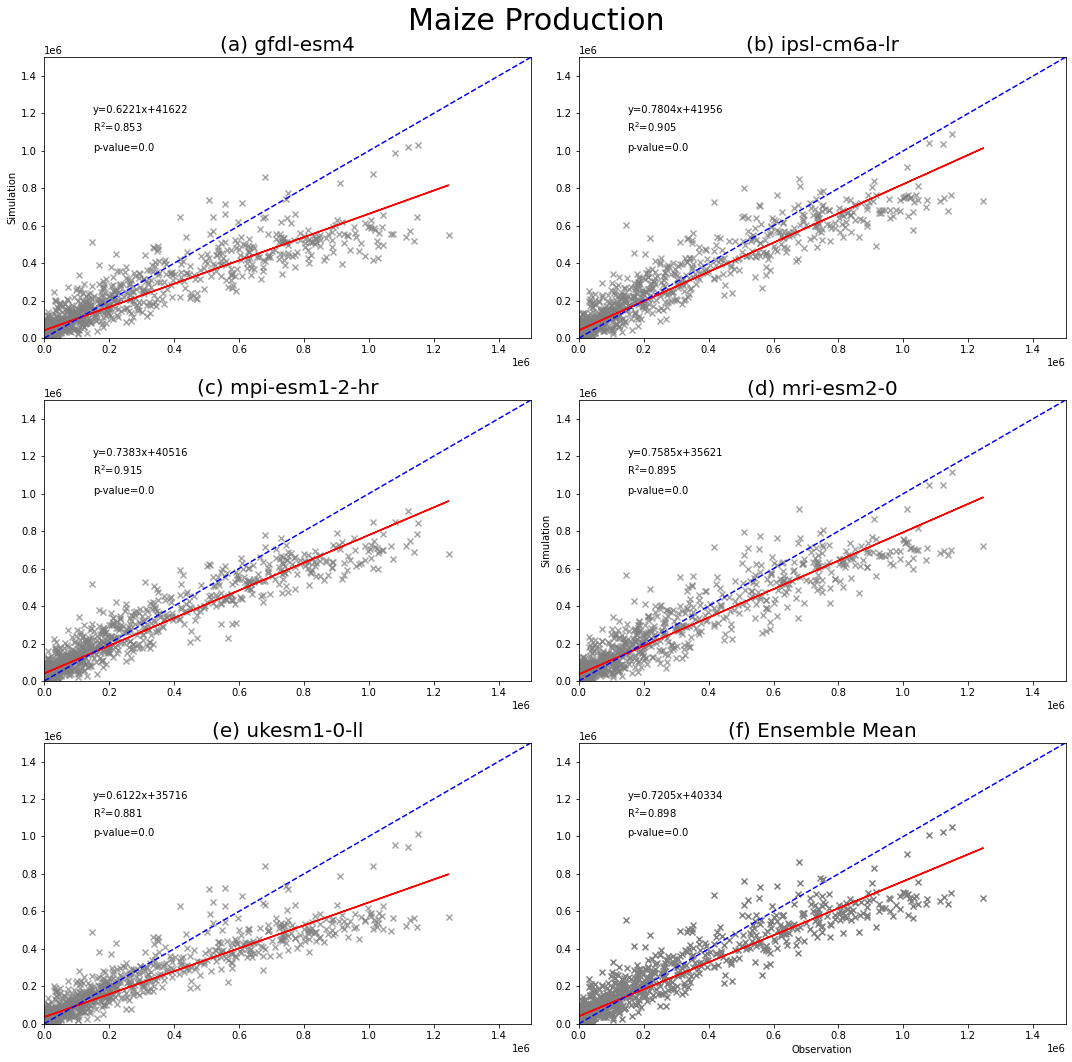

In [30]:
name_gcms=['(a) gfdl-esm4','(b) ipsl-cm6a-lr','(c) mpi-esm1-2-hr','(d) mri-esm2-0','(e) ukesm1-0-ll']
fig, axes = plt.subplots(3, 2, figsize=(15, 15))
axes = axes.flatten()
ii=0
mp1=np.nanmean(prod60X60,axis=2)
for igcm in range(5):

    data=mp1[:,:,igcm]
        
    X = all_prod2000_60x60.ravel()
    Y = data.ravel()
    X[X<=0]=np.nan
    Y[Y<=0]=np.nan
    mask = [~np.isnan(X) & ~np.isnan(Y)] 
    X=X[mask]
    Y=Y[mask]
    if len(X)==0:
        ii=ii+1
        continue
    # Add a constant term to the independent variable for intercept estimation
    X_with_const = sm.add_constant(X)

    # Fit the linear regression model
    model = sm.OLS(Y, X_with_const)
    results = model.fit()

    # Print the summary
    #print(results.summary())            
    coefficients1 = np.polyfit(X, Y, 1)
    regression_line1 = np.polyval(coefficients1, X)
    
    ax=axes[ii]
    ax.scatter(X,Y,color='grey', marker='x',alpha=0.7,  label='Data Points') 
    ax.plot(X, regression_line1, color='red')
    ax.text(150000,1200000, 'y='+str(round(coefficients1[0],4))+'x+'+str(int(coefficients1[1])))
    ax.text(150000,1100000, 'R$^2$='+str(round(results.rsquared,3)))
    ax.text(150000,1000000, 'p-value='+str(round(results.pvalues[1],3)))
    ax.set_xlim([0,1500000])
    ax.set_ylim([0,1500000])
    x_values = np.linspace(0, 1500000, 1000000)

    # Plot the dashed line y = x
    ax.plot(x_values, x_values, linestyle='--', color='blue', label='y = x')    
    if (ii>8):
        ax.set_xlabel('Observation')
    if (ii==0 or ii==3 or ii==6 or ii==9):
        ax.set_ylabel('Simulation')
    plt.title('Production')
    ax.set_title(name_gcms[ii], fontsize=20)

#     ax.set_xlim(0,15)
#     ax.set_ylim(0,15)    
    ii=ii+1
data=np.nanmean(np.nanmean(prod60X60,axis=3),axis=2)
# #/spam_production
X = all_prod2000_60x60.ravel()
Y=data.ravel()
X[X<=0]=np.nan
Y[Y<=0]=np.nan
mask = ~np.isnan(X) & ~np.isnan(Y) 
X=X[mask]
Y=Y[mask]
# Add a constant term to the independent variable for intercept estimation
X_with_const = sm.add_constant(X)
# Fit the linear regression model
model = sm.OLS(Y, X_with_const)
results = model.fit()
# Print the summary
print(results.summary())  

coefficients1 = np.polyfit(X, Y, 1)
regression_line1 = np.polyval(coefficients1, X)
    
ax=axes[ii]
ax.scatter(X,Y,color='grey', marker='x', label='Data Points') 
ax.plot(X, regression_line1, color='red')
ax.text(150000,1200000, 'y='+str(round(coefficients1[0],4))+'x+'+str(int(coefficients1[1])))
ax.text(150000,1100000, 'R$^2$='+str(round(results.rsquared,3)))
ax.text(150000,1000000, 'p-value='+str(round(results.pvalues[1],3)))
ax.set_xlim([0,1500000])
ax.set_ylim([0,1500000])
x_values = np.linspace(0, 1500000, 1000000)

# Plot the dashed line y = x
ax.plot(x_values, x_values, linestyle='--', color='blue', label='y = x')
plt.xlabel('Observation')
#plt.ylabel('Simulation')
plt.suptitle('Maize Production', fontsize=30)
ax.set_title("(f) Ensemble Mean", fontsize=20)
plt.tight_layout()
fig.savefig('isimip3b_historical_production_observation_simulation_regression_for_maize_gcms_2000.png',dpi=150)

In [31]:
print([np.nansum(X),np.nansum(Y),np.nansum(Y)-np.nansum(X), np.nansum(Y)/np.nansum(X),np.nansum(Y)/np.nansum(X)-1])

[240577783.0715948, 223644573.90365, -16933209.16794482, 0.9296144101431612, -0.07038558985683885]


For the single year 2000, the simulated production is less than observation 7%. 

## for single year 2005

In [33]:
#check if all data are available
# define an array to store percentiles 25th, 50th and 75th 5th and 95th percentiles
prod60X60=np.full((60, 60, 12,5), np.nan)  #X, Y, ggcm,gcm 
ratio60X60=np.full((60, 60, 60), np.nan)  #X, Y, Simulations 
ptl=np.full((60, 5), np.nan) 
ptl50=np.full((12,5),np.nan) #save median as 12X5 array 
ij=0
ii=0

for ggcm in ggcms:  #crop models
    jj=0
    for gcm in gcms:   #climate models
        s1="/media/Data1/Climada/ISIMIP3b/Data/"
        s2=ggcm+'_'+gcm
        s3='_w5e5_historical_2015soc_default_yield-mai-*.nc'  #maize yield data files
        s4=s1+s2+'_w5e5_historical_2015soc_default_yield-mai-firr*.nc'    #irrigated
        s5=s1+s2+'_w5e5_historical_2015soc_default_yield-mai-noirr*.nc'   #rainfed
        ss=s1+s2+s3  #maize yield files, to check if there are 2 files
        fns=glob.glob(ss)
        if len(fns)<2:  
            print(ggcm+' '+gcm+' '+str(len(fns)))
            continue
        else:
            #irrigated
            fns1=glob.glob(s4)
            #print(fns1[0])
            file1=fns1[0]   #irrigated file
            ds=xr.open_dataset(file1,decode_times=False)
            # substract data for the last 19 years, 1996 to 2014
            cropped_ds = ds.sel(lat=slice(max_lat,min_lat), lon=slice(min_lon,max_lon), time=slice(404,404))
                #average over years rainfed
            crop_isimip3b1_mean=cropped_ds.mean(dim='time')*irrigated_landuse/100
            
            #rainfed maize file
            fns2=glob.glob(s5)
            #print(fns2[0])
            file1=fns2[0]
            ds=xr.open_dataset(file1,decode_times=False)
            cropped_ds = ds.sel(lat=slice(max_lat,min_lat), lon=slice(min_lon,max_lon), time=slice(404,404))
                #average over years and sum over rainfed
            crop_isimip3b2_mean=cropped_ds.mean(dim='time')*rainfed_landuse/100  #average over time and landuse (%)         
            # combined yield for each grid
            crop_isimip3b_mean= crop_isimip3b1_mean['yield-mai-firr'].fillna(0) \
                                +crop_isimip3b2_mean['yield-mai-noirr'].fillna(0)
            #production on each grid: 1ha = 10000 m^2
            prod=crop_isimip3b_mean*areainsqmeter/10000
            
            #check the ratio rather than absolute production
            ratio=prod/spam_production
            prod60X60[:,:,ii,jj]=prod
            ratio60X60[:,:,ij]=ratio
            d1=np.array(ratio).ravel()


            d2=d1[~np.isnan(d1)]  #remove grid without maize
            d2=d2[d2>0]   #remove grid with production<=0
            percentile_75 = np.percentile(d2, 75)   #75th percentiles
            percentile_25 = np.percentile(d2, 25)   #25th percentiles
            percentile_50 = np.percentile(d2, 50)   #50th percentiles or mediean values         
            d95=np.nanpercentile(d2, 95)  #95th percentile
            d05=np.nanpercentile(d2, 5)   #5th percentile
            d3=d2[d2<d95]   #remove extreme high values
            d3=d3[d3>d05]   #remove extreme low values

            ptl[ij,:]=[percentile_25,percentile_50,percentile_75, d05,d95]  #save 25th, 50th and 75th percentiles
            print(len(d2),[d05,percentile_25,percentile_50,percentile_75,d95],len(d3)) #display results
            ptl50[ii,jj]=percentile_50
            ij=ij+1
        jj=jj+1
    ii=ii+1
            

acea gfdl-esm4 0
acea ipsl-cm6a-lr 0
acea mpi-esm1-2-hr 0
1238 [0.27082919005214556, 1.1376481231741131, 1.9046249413662997, 4.695968093867504, 31.73767664682029] 1114
1260 [0.7181542664370077, 1.134112079531182, 1.8651393838608439, 4.327086296449057, 33.55904639237235] 1134
1219 [0.3518824983135474, 0.5644638588447115, 0.9058908158220339, 1.94607851688836, 13.88319873936982] 1097
1215 [0.3174713982531407, 0.48678297204976384, 0.8183254183980448, 1.8386710214227218, 13.833654119936249] 1093
1219 [0.2532106364541603, 0.49342648524439714, 0.8345011533953879, 1.9120153784506098, 14.549398646945635] 1097
1219 [0.2710345460218593, 0.5235315302625094, 0.8520514277443445, 1.9364369883273067, 12.849680054387434] 1097
1219 [0.3374669848049805, 0.5220494946576775, 0.8574818481992623, 1.9016741000894433, 14.203932615311665] 1097
1261 [0.5022662271057039, 0.9273417044225601, 1.446213365620097, 3.099390875817865, 25.76672650244356] 1133
1261 [0.4232047131880437, 0.6794368004205611, 1.25081037498980

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.880
Model:                            OLS   Adj. R-squared:                  0.880
Method:                 Least Squares   F-statistic:                     8094.
Date:                Fri, 23 Feb 2024   Prob (F-statistic):               0.00
Time:                        16:16:18   Log-Likelihood:                -13873.
No. Observations:                1105   AIC:                         2.775e+04
Df Residuals:                    1103   BIC:                         2.776e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       5.146e+04   2562.174     20.086      0.0

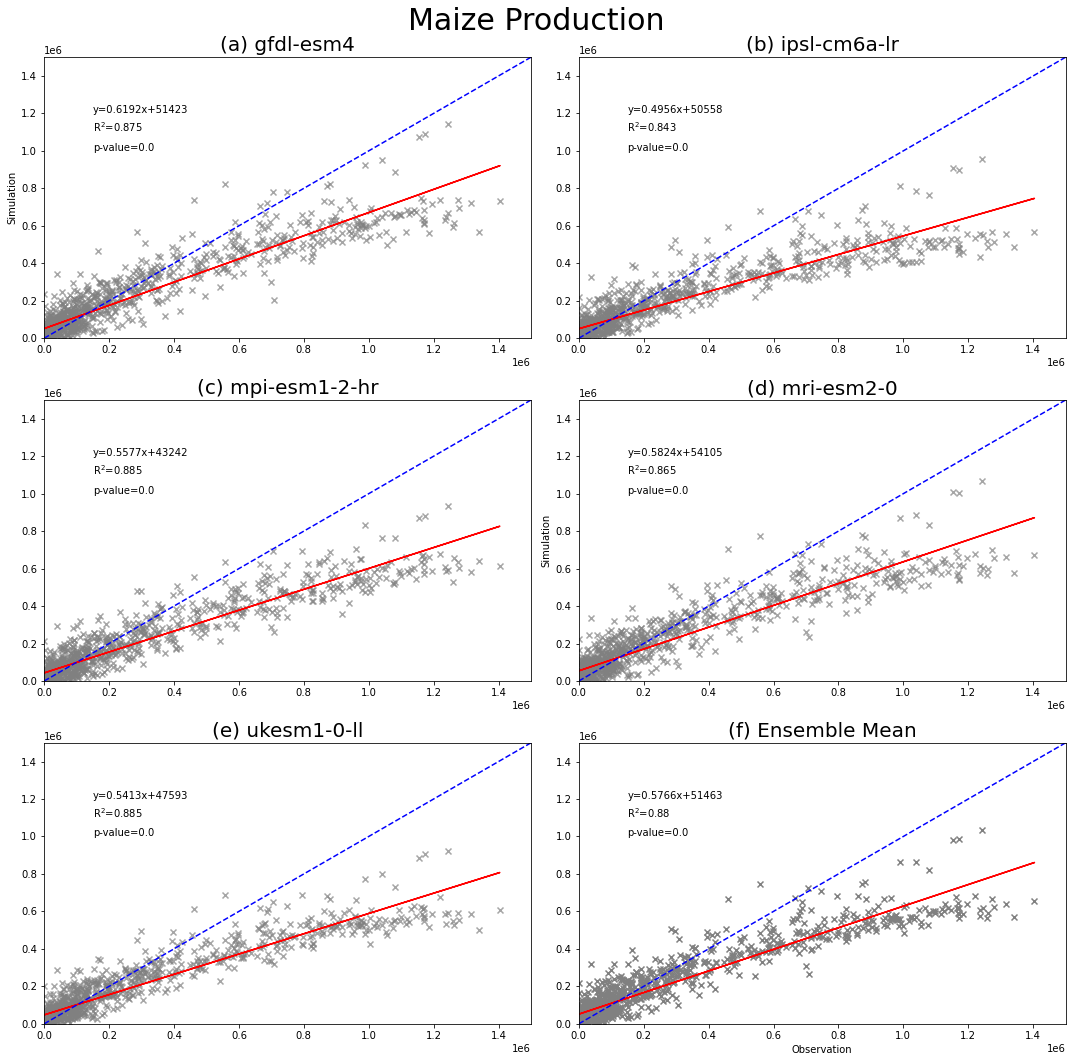

In [34]:
name_gcms=['(a) gfdl-esm4','(b) ipsl-cm6a-lr','(c) mpi-esm1-2-hr','(d) mri-esm2-0','(e) ukesm1-0-ll']
fig, axes = plt.subplots(3, 2, figsize=(15, 15))
axes = axes.flatten()
ii=0
mp1=np.nanmean(prod60X60,axis=2)
for igcm in range(5):

    data=mp1[:,:,igcm]
        
    X = all_prod2005_60x60.ravel()
    Y = data.ravel()
    X[X<=0]=np.nan
    Y[Y<=0]=np.nan
    mask = [~np.isnan(X) & ~np.isnan(Y)] 
    X=X[mask]
    Y=Y[mask]
    if len(X)==0:
        ii=ii+1
        continue
    # Add a constant term to the independent variable for intercept estimation
    X_with_const = sm.add_constant(X)

    # Fit the linear regression model
    model = sm.OLS(Y, X_with_const)
    results = model.fit()

    # Print the summary
    #print(results.summary())            
    coefficients1 = np.polyfit(X, Y, 1)
    regression_line1 = np.polyval(coefficients1, X)
    
    ax=axes[ii]
    ax.scatter(X,Y,color='grey', marker='x',alpha=0.7,  label='Data Points') 
    ax.plot(X, regression_line1, color='red')
    ax.text(150000,1200000, 'y='+str(round(coefficients1[0],4))+'x+'+str(int(coefficients1[1])))
    ax.text(150000,1100000, 'R$^2$='+str(round(results.rsquared,3)))
    ax.text(150000,1000000, 'p-value='+str(round(results.pvalues[1],3)))
    ax.set_xlim([0,1500000])
    ax.set_ylim([0,1500000])
    x_values = np.linspace(0, 1500000, 1000000)

    # Plot the dashed line y = x
    ax.plot(x_values, x_values, linestyle='--', color='blue', label='y = x')    
    if (ii>8):
        ax.set_xlabel('Observation')
    if (ii==0 or ii==3 or ii==6 or ii==9):
        ax.set_ylabel('Simulation')
    plt.title('Production')
    ax.set_title(name_gcms[ii], fontsize=20)

#     ax.set_xlim(0,15)
#     ax.set_ylim(0,15)    
    ii=ii+1
data=np.nanmean(np.nanmean(prod60X60,axis=3),axis=2)
# #/spam_production
X = all_prod2005_60x60.ravel()
Y=data.ravel()
X[X<=0]=np.nan
Y[Y<=0]=np.nan
mask = ~np.isnan(X) & ~np.isnan(Y) 
X=X[mask]
Y=Y[mask]
# Add a constant term to the independent variable for intercept estimation
X_with_const = sm.add_constant(X)
# Fit the linear regression model
model = sm.OLS(Y, X_with_const)
results = model.fit()
# Print the summary
print(results.summary())  

coefficients1 = np.polyfit(X, Y, 1)
regression_line1 = np.polyval(coefficients1, X)
    
ax=axes[ii]
ax.scatter(X,Y,color='grey', marker='x', label='Data Points') 
ax.plot(X, regression_line1, color='red')
ax.text(150000,1200000, 'y='+str(round(coefficients1[0],4))+'x+'+str(int(coefficients1[1])))
ax.text(150000,1100000, 'R$^2$='+str(round(results.rsquared,3)))
ax.text(150000,1000000, 'p-value='+str(round(results.pvalues[1],3)))
ax.set_xlim([0,1500000])
ax.set_ylim([0,1500000])
x_values = np.linspace(0, 1500000, 1000000)

# Plot the dashed line y = x
ax.plot(x_values, x_values, linestyle='--', color='blue', label='y = x')
plt.xlabel('Observation')
#plt.ylabel('Simulation')
plt.suptitle('Maize Production', fontsize=30)
ax.set_title("(f) Ensemble Mean", fontsize=20)
plt.tight_layout()
fig.savefig('isimip3b_historical_production_observation_simulation_regression_for_maize_gcms_2005.png',dpi=150)

In [35]:
print([np.nansum(X),np.nansum(Y),np.nansum(Y)-np.nansum(X), np.nansum(Y)/np.nansum(X),np.nansum(Y)/np.nansum(X)-1])

[261358774.03696972, 207557067.50799426, -53801706.52897546, 0.7941461627710072, -0.20585383722899275]


For the single year 2005, the simulated production is less than observation 20.6%. 

## for single year 2010

In [22]:
#check if all data are available
# define an array to store percentiles 25th, 50th and 75th 5th and 95th percentiles
prod60X60=np.full((60, 60, 12,5), np.nan)  #X, Y, ggcm,gcm 
ratio60X60=np.full((60, 60, 60), np.nan)  #X, Y, Simulations 
ptl=np.full((60, 5), np.nan) 
ptl50=np.full((12,5),np.nan) #save median as 12X5 array 
ij=0
ii=0

for ggcm in ggcms:  #crop models
    jj=0
    for gcm in gcms:   #climate models
        s1="/media/Data1/Climada/ISIMIP3b/Data/"
        s2=ggcm+'_'+gcm
        s3='_w5e5_historical_2015soc_default_yield-mai-*.nc'  #maize yield data files
        s4=s1+s2+'_w5e5_historical_2015soc_default_yield-mai-firr*.nc'    #irrigated
        s5=s1+s2+'_w5e5_historical_2015soc_default_yield-mai-noirr*.nc'   #rainfed
        ss=s1+s2+s3  #maize yield files, to check if there are 2 files
        fns=glob.glob(ss)
        if len(fns)<2:  
            print(ggcm+' '+gcm+' '+str(len(fns)))
            continue
        else:
            #irrigated
            fns1=glob.glob(s4)
            #print(fns1[0])
            file1=fns1[0]   #irrigated file
            ds=xr.open_dataset(file1,decode_times=False)
            # substract data for the last 19 years, 1996 to 2014
            cropped_ds = ds.sel(lat=slice(max_lat,min_lat), lon=slice(min_lon,max_lon), time=slice(409,409))
                #average over years rainfed
            crop_isimip3b1_mean=cropped_ds.mean(dim='time')*irrigated_landuse/100
            
            #rainfed maize file
            fns2=glob.glob(s5)
            #print(fns2[0])
            file1=fns2[0]
            ds=xr.open_dataset(file1,decode_times=False)
            cropped_ds = ds.sel(lat=slice(max_lat,min_lat), lon=slice(min_lon,max_lon), time=slice(409,409))
                #average over years and sum over rainfed
            crop_isimip3b2_mean=cropped_ds.mean(dim='time')*rainfed_landuse/100  #average over time and landuse (%)         
            # combined yield for each grid
            crop_isimip3b_mean= crop_isimip3b1_mean['yield-mai-firr'].fillna(0) \
                                +crop_isimip3b2_mean['yield-mai-noirr'].fillna(0)
            #production on each grid: 1ha = 10000 m^2
            prod=crop_isimip3b_mean*areainsqmeter/10000
            
            #check the ratio rather than absolute production
            ratio=prod/spam_production
            prod60X60[:,:,ii,jj]=prod
            ratio60X60[:,:,ij]=ratio
            d1=np.array(ratio).ravel()


            d2=d1[~np.isnan(d1)]  #remove grid without maize
            d2=d2[d2>0]   #remove grid with production<=0
            percentile_75 = np.percentile(d2, 75)   #75th percentiles
            percentile_25 = np.percentile(d2, 25)   #25th percentiles
            percentile_50 = np.percentile(d2, 50)   #50th percentiles or mediean values         
            d95=np.nanpercentile(d2, 95)  #95th percentile
            d05=np.nanpercentile(d2, 5)   #5th percentile
            d3=d2[d2<d95]   #remove extreme high values
            d3=d3[d3>d05]   #remove extreme low values

            ptl[ij,:]=[percentile_25,percentile_50,percentile_75, d05,d95]  #save 25th, 50th and 75th percentiles
            print(len(d2),[d05,percentile_25,percentile_50,percentile_75,d95],len(d3)) #display results
            ptl50[ii,jj]=percentile_50
            ij=ij+1
        jj=jj+1
    ii=ii+1
            

acea gfdl-esm4 0
acea ipsl-cm6a-lr 0
acea mpi-esm1-2-hr 0
1261 [0.6370361055423572, 1.1052929814355161, 1.7972210052381072, 4.4280827338995685, 30.96546704080109] 1133
1261 [0.5980372443806924, 1.0389687322387169, 1.7393109669528477, 4.26662034963102, 28.914837823216843] 1133
1219 [0.3261245612585738, 0.525040096317938, 0.8630727447110524, 1.9528240291313863, 13.96963614021991] 1097
1219 [0.3286045714027832, 0.5253246303071832, 0.8720307616676736, 1.9795102397865512, 13.921108034880914] 1097
1219 [0.3142890630823556, 0.5329713589560414, 0.8703939529573957, 1.980992930105579, 13.915164413916532] 1097
1219 [0.3296247030120419, 0.5377242411282281, 0.8894171144366282, 2.0112998065678633, 14.290565972940405] 1097
1219 [0.3162816391986316, 0.5163024881941471, 0.8497909130295525, 1.927681216529964, 13.419263478137797] 1097
1261 [0.4668031435078649, 0.7793110368360634, 1.3385483750879044, 3.1090464567609253, 24.73440721863427] 1133
1261 [0.48899939192630165, 0.755053061974218, 1.30813010321897

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.894
Model:                            OLS   Adj. R-squared:                  0.894
Method:                 Least Squares   F-statistic:                 1.004e+04
Date:                Fri, 23 Feb 2024   Prob (F-statistic):               0.00
Time:                        16:18:33   Log-Likelihood:                -14906.
No. Observations:                1194   AIC:                         2.982e+04
Df Residuals:                    1192   BIC:                         2.983e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.124e+04   2280.672     18.083      0.0

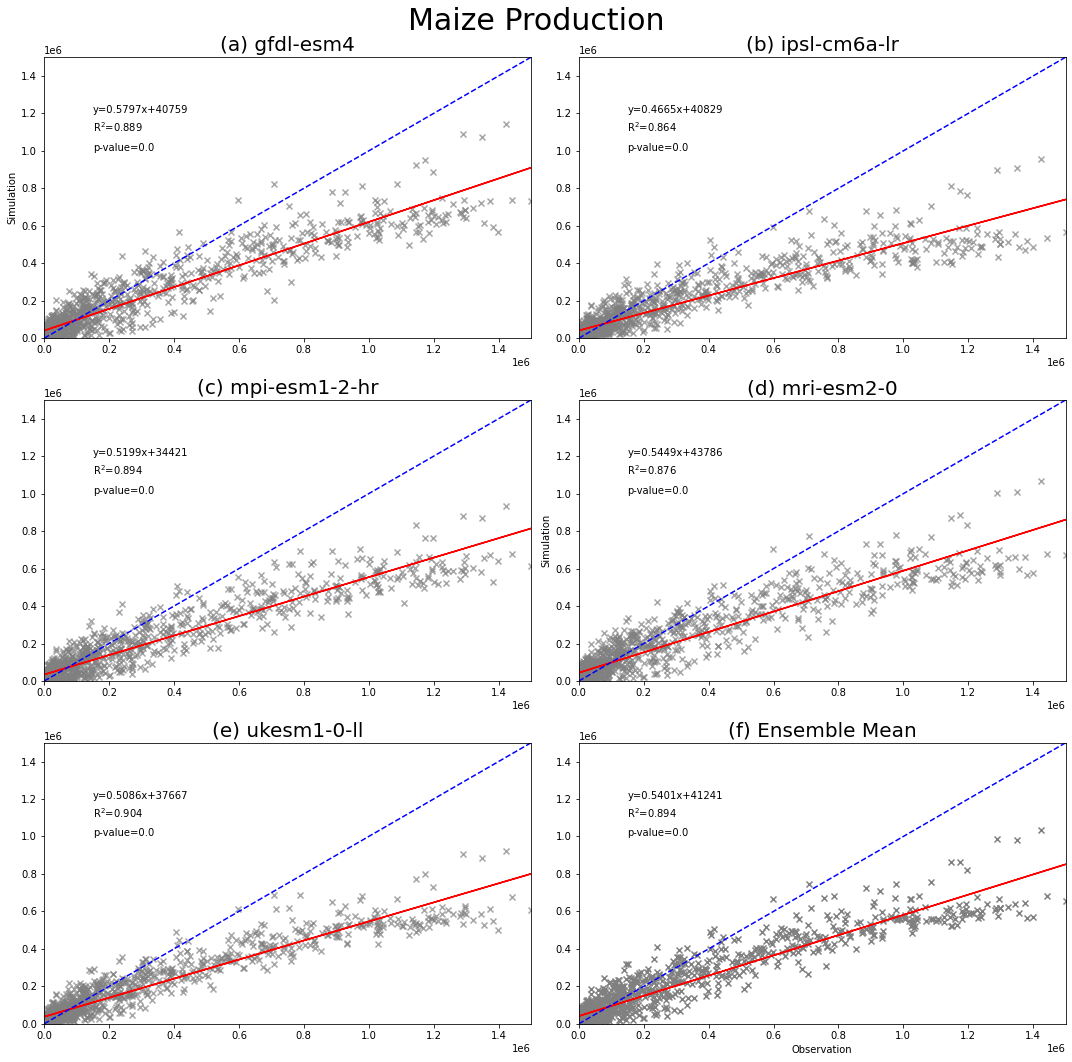

In [36]:
name_gcms=['(a) gfdl-esm4','(b) ipsl-cm6a-lr','(c) mpi-esm1-2-hr','(d) mri-esm2-0','(e) ukesm1-0-ll']
fig, axes = plt.subplots(3, 2, figsize=(15, 15))
axes = axes.flatten()
ii=0
mp1=np.nanmean(prod60X60,axis=2)
for igcm in range(5):

    data=mp1[:,:,igcm]
        
    X = all_prod2010_60x60.ravel()
    Y = data.ravel()
    X[X<=0]=np.nan
    Y[Y<=0]=np.nan
    mask = [~np.isnan(X) & ~np.isnan(Y)] 
    X=X[mask]
    Y=Y[mask]
    if len(X)==0:
        ii=ii+1
        continue
    # Add a constant term to the independent variable for intercept estimation
    X_with_const = sm.add_constant(X)

    # Fit the linear regression model
    model = sm.OLS(Y, X_with_const)
    results = model.fit()

    # Print the summary
    #print(results.summary())            
    coefficients1 = np.polyfit(X, Y, 1)
    regression_line1 = np.polyval(coefficients1, X)
    
    ax=axes[ii]
    ax.scatter(X,Y,color='grey', marker='x',alpha=0.7,  label='Data Points') 
    ax.plot(X, regression_line1, color='red')
    ax.text(150000,1200000, 'y='+str(round(coefficients1[0],4))+'x+'+str(int(coefficients1[1])))
    ax.text(150000,1100000, 'R$^2$='+str(round(results.rsquared,3)))
    ax.text(150000,1000000, 'p-value='+str(round(results.pvalues[1],3)))
    ax.set_xlim([0,1500000])
    ax.set_ylim([0,1500000])
    x_values = np.linspace(0, 1500000, 1000000)

    # Plot the dashed line y = x
    ax.plot(x_values, x_values, linestyle='--', color='blue', label='y = x')    
    if (ii>8):
        ax.set_xlabel('Observation')
    if (ii==0 or ii==3 or ii==6 or ii==9):
        ax.set_ylabel('Simulation')
    plt.title('Production')
    ax.set_title(name_gcms[ii], fontsize=20)

#     ax.set_xlim(0,15)
#     ax.set_ylim(0,15)    
    ii=ii+1
data=np.nanmean(np.nanmean(prod60X60,axis=3),axis=2)
# #/spam_production
X = all_prod2010_60x60.ravel()
Y=data.ravel()
X[X<=0]=np.nan
Y[Y<=0]=np.nan
mask = ~np.isnan(X) & ~np.isnan(Y) 
X=X[mask]
Y=Y[mask]
# Add a constant term to the independent variable for intercept estimation
X_with_const = sm.add_constant(X)
# Fit the linear regression model
model = sm.OLS(Y, X_with_const)
results = model.fit()
# Print the summary
print(results.summary())  

coefficients1 = np.polyfit(X, Y, 1)
regression_line1 = np.polyval(coefficients1, X)
    
ax=axes[ii]
ax.scatter(X,Y,color='grey', marker='x', label='Data Points') 
ax.plot(X, regression_line1, color='red')
ax.text(150000,1200000, 'y='+str(round(coefficients1[0],4))+'x+'+str(int(coefficients1[1])))
ax.text(150000,1100000, 'R$^2$='+str(round(results.rsquared,3)))
ax.text(150000,1000000, 'p-value='+str(round(results.pvalues[1],3)))
ax.set_xlim([0,1500000])
ax.set_ylim([0,1500000])
x_values = np.linspace(0, 1500000, 1000000)

# Plot the dashed line y = x
ax.plot(x_values, x_values, linestyle='--', color='blue', label='y = x')
plt.xlabel('Observation')
#plt.ylabel('Simulation')
plt.suptitle('Maize Production', fontsize=30)
ax.set_title("(f) Ensemble Mean", fontsize=20)
plt.tight_layout()
fig.savefig('isimip3b_historical_production_observation_simulation_regression_for_maize_gcms_2010.png',dpi=150)

In [37]:
print([np.nansum(X),np.nansum(Y),np.nansum(Y)-np.nansum(X), np.nansum(Y)/np.nansum(X),np.nansum(Y)/np.nansum(X)-1])

[295184407.4119165, 208660836.01184, -86523571.40007651, 0.7068829883031837, -0.29311701169681625]


In the year 2010, the simulated production is 29.3 less than observation. 

## plot histogram of 25th, 50th and 75th percentiles of 52 runs

52


Text(0.5, 1.0, '(c) 75th percentile')

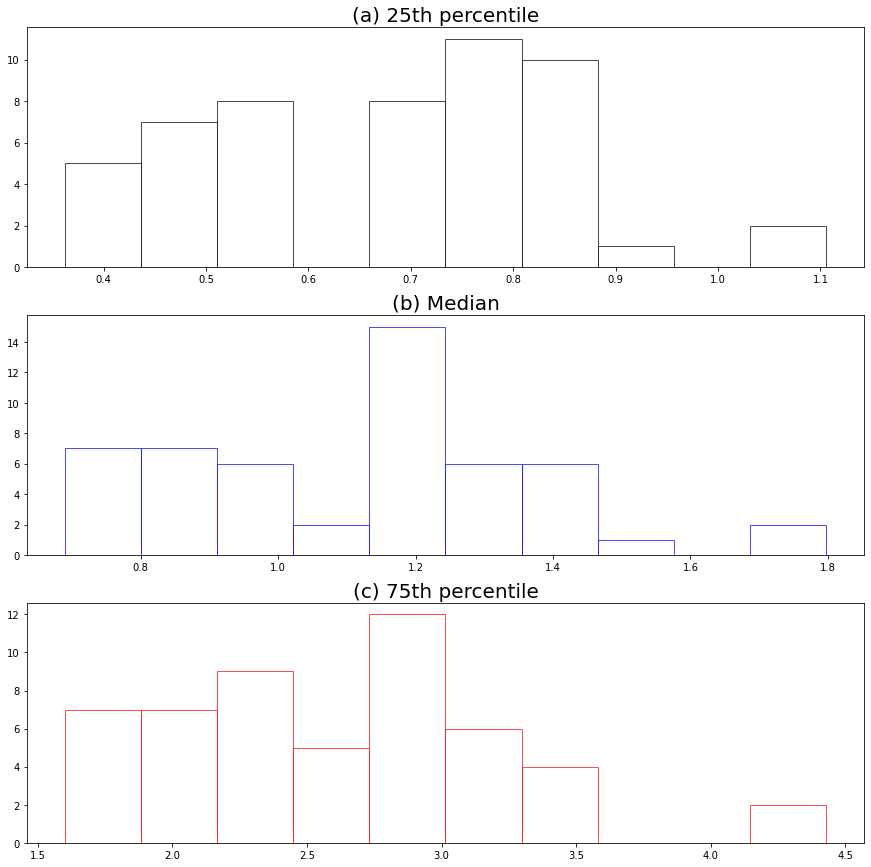

In [10]:
fig, axes = plt.subplots(3, 1, figsize=(15, 15))
axes = axes.flatten()
data1=ptl[:,0]
data1=data1[~np.isnan(data1)]
print(len(data1))
axes[0].hist(data1, bins=10, edgecolor='black',color='white', alpha=0.7) 
data2=ptl[:,1]
data2=data2[~np.isnan(data2)]
#print(len(data1))
axes[1].hist(data2, bins=10, edgecolor='blue',color='white', alpha=0.7) 
data3=ptl[:,2]
data3=data3[~np.isnan(data3)]
#print(len(data1))
axes[2].hist(data3, bins=10, edgecolor='red',color='white', alpha=0.7) 
# axes[0].set_xlim(0,4)
# axes[1].set_xlim(0,4)
# axes[2].set_xlim(0,4)
axes[0].set_title('(a) 25th percentile',fontsize=20)
axes[1].set_title('(b) Median', fontsize=20)

axes[2].set_title('(c) 75th percentile',fontsize=20)

In [11]:
print('5th percentles min, median and max',[np.nanmin(ptl[:,3]),np.nanmedian(ptl[:,3]),np.nanmax(ptl[:,3])])

5th percentles min, median and max [0.1386147612054058, 0.4405199775790033, 0.6370361055423572]


In [12]:
print('25th percentles min, median and max',[np.min(data1),np.median(data1),np.max(data1)])

25th percentles min, median and max [0.36235286748748574, 0.7222018131901231, 1.1052929814355161]


In [13]:
print('25th percentles min, median and max',[np.min(data2),np.median(data2),np.max(data2)])

25th percentles min, median and max [0.6897142109162644, 1.1772827862133153, 1.7972210052381072]


In [14]:
print('75th percentles min, median and max',[np.min(data3),np.median(data3),np.max(data3)])

75th percentles min, median and max [1.6011820878265932, 2.680097295549972, 4.4280827338995685]


In [15]:
print('95th percentles min, median and max',[np.nanmin(ptl[:,4]),np.nanmedian(ptl[:,4]),np.nanmax(ptl[:,4])])

95th percentles min, median and max [12.659074587452873, 20.134509930910326, 30.96546704080109]


Figure: Distribution of (a) medians; (b) 25th percentiles and (c) 75th percentiles of the ratios of simulated poduction to observation.
The 52 simulations are driven by simulated climate variables generated by 5 GCMs for the period 1996 to 2014. The ratios are calculated grid by grid within the study area, which comprises 1263 grid cells with valid ratio values. Grids with NaN or zero production values in either the simulated or observed production are excluded when calculating the ratios. To focus on the general trend, the histogram plots only include ratios within the 90th percentile range (5th to 95th percentile) to exclude extreme situations where simulated or observed values are very small, typically occurring in grid cells with maize land use fractions below 0.1%.

### summarize the results:
The median values of the ratios across all simulations generally fall within the range of 0.7 to 1.5, with 25th percentiles ranging from 0.3 to 1.1 and 75th percentiles ranging from 1.6 to 4.5. The 5th percentiles range from 0.13 to 0.64, while the 95th percentiles span from 12 to 31. This distribution suggests that approximately half of the grid cells exhibit similar levels of modeled production and observed production. Although the median value slightly exceeds 1.0, its proximity to 1 indicates that the models adequately capture the principal impacts of climate on maize production.

In [16]:
# Find rows with all elements as np.nan
nan_rows = np.all(np.isnan(ptl50), axis=1)

# Delete rows with all elements as np.nan
ptl50 = ptl50[~nan_rows]
# ggcms=['acea','crover','cygma1p74','dssat-pythia','epic-iiasa','isam',
#        'ldndc','lpjml','pdssat','pepic','promet','simplace-lintul5']
ggcms1=['acea','crover','cygma1p74','dssat-pythia','epic-iiasa',
       'ldndc','lpjml','pdssat','pepic','promet','simplace-lintul5']


## Check the difference among simulations

In [17]:
[np.nanmin(ptl50),np.nanmax(ptl50)]

[0.6897142109162644, 1.7972210052381072]

In [18]:
[np.nanpercentile(ptl50,25),np.nanpercentile(ptl50,75)]

[0.9102965733659583, 1.2610261454134868]

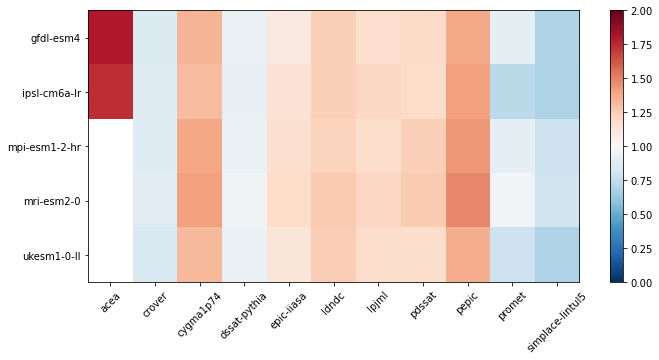

In [19]:
# import matplotlib.colors as mcolors
fig = plt.figure(figsize=(11, 5))
cmap='RdBu_r'
# cmap.set_bad(color='grey')
plt.imshow(np.transpose(ptl50), cmap=cmap, vmin=0.0, vmax=2, aspect='auto')
# Set ticks and labels
plt.yticks(np.arange(len(gcms)), gcms, ha='right')
plt.xticks(np.arange(len(ggcms1)), ggcms1, rotation=45)

plt.colorbar()  # Optionally add a color bar
plt.show()

Figure: Variation of Median Ratios Across GCM-GGCM Combinations

The color-coded representation illustrates the variation in median ratios across different combinations of General Circulation Models (GCMs) and Global Gridded Crop Models (GGCMs). Ratios less than 1 are depicted in white to blue color gradients, while values greater than 1 are depicted in white to red color gradients. The intensity of the color indicates the magnitude of the ratio, with bluer shades representing lower values and redder shades indicating higher values. Although the ratio values range from 0.69 to 1.80, the color bar is symmetrically scaled from 0 to 2 to maintain visual consistency, with the midpoint at 1.0. The vertical axis corresponds to the 5 GCMs, while the horizontal axis represents the 11 GGCMs.

### Figure summary:
The study results indicate that the median ratios across the 52 simulations range from 0.69 to 1.80. Visual inspection of the figure reveals that, with few exceptions, the majority of simulations produced maize yields closely aligned with observed values, as evidenced by a median ratio value close to 1.0. While some simulations underestimated production, a greater number overestimated it, mirroring patterns observed in simulations driven by realistic observed climate variables for the same period. This suggests that the crop models utilized in the study effectively capture the impacts of climate on maize production in the study area. However, given the inherent imperfections of the models and the use of constant social forcing from 2015, perfect matching between observation and simulation is unattainable. In subsequent studies, the combination of observational data and relative production will be employed to assess the risks associated with maize production.

## Spatial distribution of median ratio

In [20]:
medianRatio=np.full((60,60),np.nan)
for i in range(60):
    for j in range(60):
        rr=ratio60X60[i,j,:]
        rr1=np.array(rr).ravel()
        rr2=rr1[~np.isnan(rr1)]  #remove grid without maize
        if len(rr2)>0:
            medianRatio[i,j]=np.nanpercentile(rr2,50)
        else:
            continue

In [21]:
provinces= ['Ontario', 'Quebec','Manitoba','Wisconsin','Vermont','Nebraska','New York','Kansas','Illinois',
            'Delaware','Connecticut','Indiana','Missouri','Michigan','New Jersey','Kentucky','Minnesota',
            'Ohio','Iowa','Pennsylvania','Maryland','Virginia','West Virginia','North Dakota','South Dakota','Nunavut']
provinces1=['ON','QC','MB','WI','VT','NE','NY','KS','IL','DE','CT','IN','MO','MI','NJ','KY','MN','OH','IA','PA','MD','VA','WV','ND','SD','NU']
Latitudes= [50,53,56.4,44.5,44,41.5,43,38.5,40,39,41.6,40.3,38.6,44.2,39.8,37.8,46.4,
            40.4,42,41.2,39,38,39,47.7,44.5,62]
Longitudes=[-85,-76,-98.7,-89.5,-72,-100,-75,-98,-89,-73.5,-72.7,-86,-92.6,-84.5,-74.9,-84.3,-94.6,
            -83,-93.6,-77.2,-76.6,-78,-80.5,-99,-99,-98]

[2.3188293111621827, -9.224917763229355]
[1.7729195811379737, -1.477248884653954]
[-0.05639254823266979, 0.0646094399641457]


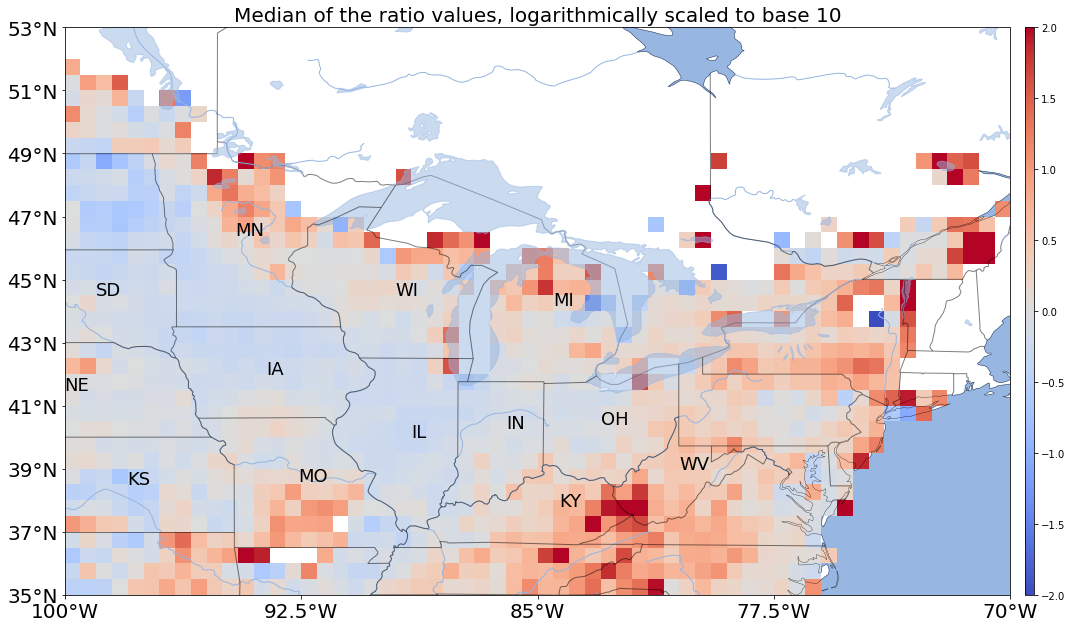

In [22]:
lats = cropped_ds.coords['lat'][:]
lons = cropped_ds.coords['lon'][:]
X,Y = np.meshgrid(lons,lats)
projection = ccrs.PlateCarree()
provinc_bodr = cartopy.feature.NaturalEarthFeature(category='cultural',
    name='admin_1_states_provinces_lines', scale='50m', facecolor='none', edgecolor='k')
axes_class = (GeoAxes,
              dict(map_projection=projection))
# lons, lats = np.meshgrid(lons, lats)
title_text=["Refereance", "2050s", "2080s"]
fig = plt.figure(figsize=(15,15))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(1, 1),
                axes_pad=0.6,
                cbar_location='right',
                cbar_mode='single',
                cbar_pad=0.2,
                cbar_size='1%',
                label_mode='')  # note the empty labe
for i, ax in enumerate(axgr):
#*************************************************************
    if i==0:
        data=medianRatio
        data=np.where(data == 0, np.nan, data)
        data=np.log10(data)
        #data=np.where(data >10, np.nan,data)
        
        subtitle="Median of the ratio values, logarithmically scaled to base 10"
        print([np.nanpercentile(data,99.0),np.nanpercentile(data,0)])
        print([np.nanpercentile(data[37:56,:40],99.0),np.nanpercentile(data[37:56,:40],0)])
        print([np.nanpercentile(data[37:56,:40],50.0),np.nanmean(data[37:56,:40])])          
    
                     
#add ocean, coastline,borders,lakes,rivers,provinc_bodr
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE,linewidth=0.3)
    ax.add_feature(cfeature.BORDERS, linestyle='-', alpha=0.5)
    ax.add_feature(cfeature.LAKES, alpha=0.5)
    ax.add_feature(cfeature.RIVERS)
    ax.add_feature(provinc_bodr, linestyle='-', linewidth=1, edgecolor="k", zorder=10, alpha=0.5)
    ax.set_title(subtitle, fontsize=20)
    ax.set_xlim([-100,-70])
    ax.set_ylim([35,53])
    ax.set_xticks(np.linspace(-100, -70, 5), crs=projection)
    ax.set_yticks(np.linspace(35, 53, 10), crs=projection)
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.tick_params(axis='x', labelsize=20)
    ax.tick_params(axis='y', labelsize=20)
    
#     p = ax.contourf(lons, lats, data,50,
#                         transform=projection,
#                         cmap='BrBG')
    
#     l = ax.contour(lons, lats, data,25,colors=['black'], linewidth=0.3,
#                         transform=ccrs.PlateCarree())
    for iprov in range(26):
        if Longitudes[iprov]<-80 and Latitudes[iprov]<47:
            ax.text(Longitudes[iprov],Latitudes[iprov],provinces1[iprov],fontsize=18)
#     p = ax.pcolormesh(X, Y, data,
#                       vmin=-300,
#                       vmax=300,
#                       transform=projection,
#                       cmap='Reds')
    p = ax.pcolormesh(X, Y, data,
                      transform=projection,
                      vmin=-2,
                      vmax=2,
                      cmap='coolwarm')    
#     ax.clabel(
#         l,  # Typically best results when labelling line contours.
#         colors=['black'],
#         manual=False,  # Automatic placement vs manual placement.
#         inline=True,  # Cut the line where the label will be placed.
#         fmt=' {:.0f} '.format,  # Labes as integers, with some extra space.
#     )
axgr.cbar_axes[0].colorbar(p)
plt.tight_layout()
plt.show()
#fig.savefig('Observational_yield_for_maize.png',dpi=150)

### figure caption:
 Spatial distribution of the median values of the ratio across the study area. Each grid cell's median value is derived from an analysis of 52 simulations. To facilitate interpretation, the medians have been logarithmically scaled to base 10. As a result, a ratio of 1 corresponds to a scaled value of 0, depicted in white-blue coloration. Ratios significantly greater than 1 are represented in red, while those substantially less than 1 are shown in blue. Grid cells depicted in white indicate areas with no current maize cultivation.

### Summary about this map:
Upon comparing this map with the maize land use distribution, it becomes evident that areas exhibiting extreme ratio values, whether high (red) or low (blue), coincide with regions characterized by minimal maize land use fraction. Conversely, within the primary maize production zones, the ratio values tend to hover around 1, as indicated by log values approaching 0. These observations collectively underscore the crop models' efficacy in adequately representing the climatic influence on maize production.

# Future projection analysis

## Check avalibility of the data
Data source:
Links
#### https://www.pik-potsdam.de/~jonasjae/
#### https://www.pik-potsdam.de/~jonasjae/GGCMI_Phase3_by_GCM_and_GGCM_1983_2099/
#### https://www.pik-potsdam.de/~jonasjae/GGCMI_Phase3_maps/
#### https://www.pik-potsdam.de/~jonasjae/GGCMI_Phase3_for_KSU_aggregation_tool/RData/


#### https://mapspam.info/data/


In [46]:
#31-year reference data 1983-2014
file1='/media/Data1/Climada/isimip3/reference/GGCMI_observational_reference_yield_map.nc4'
ds=xr.open_dataset(file1)

In [47]:
ds

<xarray.Dataset>
Dimensions:     (lon: 720, lat: 360, crop: 4, irrigation: 3)
Coordinates:
  * lon         (lon) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * lat         (lat) float64 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * crop        (crop) int32 1 2 3 4
  * irrigation  (irrigation) int32 1 2 3
Data variables:
    yield       (irrigation, crop, lat, lon) float64 ...

In [48]:
#check if all data are available
fns=glob.glob("/media/Data1/Climada/isimip3/nc4/GGCMI_Phase3_annual_ssp585_gfdl-esm4_*.nc4")
len(fns)


12

In [49]:
fns

['/media/Data1/Climada/isimip3/nc4/GGCMI_Phase3_annual_ssp585_gfdl-esm4_isam.nc4',
 '/media/Data1/Climada/isimip3/nc4/GGCMI_Phase3_annual_ssp585_gfdl-esm4_dssat-pythia.nc4',
 '/media/Data1/Climada/isimip3/nc4/GGCMI_Phase3_annual_ssp585_gfdl-esm4_pdssat.nc4',
 '/media/Data1/Climada/isimip3/nc4/GGCMI_Phase3_annual_ssp585_gfdl-esm4_pepic.nc4',
 '/media/Data1/Climada/isimip3/nc4/GGCMI_Phase3_annual_ssp585_gfdl-esm4_epic-iiasa.nc4',
 '/media/Data1/Climada/isimip3/nc4/GGCMI_Phase3_annual_ssp585_gfdl-esm4_acea.nc4',
 '/media/Data1/Climada/isimip3/nc4/GGCMI_Phase3_annual_ssp585_gfdl-esm4_ldndc.nc4',
 '/media/Data1/Climada/isimip3/nc4/GGCMI_Phase3_annual_ssp585_gfdl-esm4_simplace-lintul5.nc4',
 '/media/Data1/Climada/isimip3/nc4/GGCMI_Phase3_annual_ssp585_gfdl-esm4_promet.nc4',
 '/media/Data1/Climada/isimip3/nc4/GGCMI_Phase3_annual_ssp585_gfdl-esm4_crover.nc4',
 '/media/Data1/Climada/isimip3/nc4/GGCMI_Phase3_annual_ssp585_gfdl-esm4_cygma1p74.nc4',
 '/media/Data1/Climada/isimip3/nc4/GGCMI_Phase3_

In [28]:
#check if all data are available
fns=glob.glob("/media/Data1/Climada/isimip3/nc4/GGCMI_Phase3_annual_ssp585_ipsl-cm6a-lr_*.nc4")
len(fns)


12

In [29]:
fns

['/media/Data1/Climada/isimip3/nc4/GGCMI_Phase3_annual_ssp585_ipsl-cm6a-lr_ldndc.nc4',
 '/media/Data1/Climada/isimip3/nc4/GGCMI_Phase3_annual_ssp585_ipsl-cm6a-lr_promet.nc4',
 '/media/Data1/Climada/isimip3/nc4/GGCMI_Phase3_annual_ssp585_ipsl-cm6a-lr_crover.nc4',
 '/media/Data1/Climada/isimip3/nc4/GGCMI_Phase3_annual_ssp585_ipsl-cm6a-lr_pdssat.nc4',
 '/media/Data1/Climada/isimip3/nc4/GGCMI_Phase3_annual_ssp585_ipsl-cm6a-lr_lpjml.nc4',
 '/media/Data1/Climada/isimip3/nc4/GGCMI_Phase3_annual_ssp585_ipsl-cm6a-lr_epic-iiasa.nc4',
 '/media/Data1/Climada/isimip3/nc4/GGCMI_Phase3_annual_ssp585_ipsl-cm6a-lr_isam.nc4',
 '/media/Data1/Climada/isimip3/nc4/GGCMI_Phase3_annual_ssp585_ipsl-cm6a-lr_acea.nc4',
 '/media/Data1/Climada/isimip3/nc4/GGCMI_Phase3_annual_ssp585_ipsl-cm6a-lr_pepic.nc4',
 '/media/Data1/Climada/isimip3/nc4/GGCMI_Phase3_annual_ssp585_ipsl-cm6a-lr_simplace-lintul5.nc4',
 '/media/Data1/Climada/isimip3/nc4/GGCMI_Phase3_annual_ssp585_ipsl-cm6a-lr_dssat-pythia.nc4',
 '/media/Data1/Clim

In [30]:
#check if all data are available
fns=glob.glob("/media/Data1/Climada/isimip3/nc4/GGCMI_Phase3_annual_ssp585_mpi-esm1-2-hr_*.nc4")
len(fns)

12

In [31]:
fns

['/media/Data1/Climada/isimip3/nc4/GGCMI_Phase3_annual_ssp585_mpi-esm1-2-hr_pdssat.nc4',
 '/media/Data1/Climada/isimip3/nc4/GGCMI_Phase3_annual_ssp585_mpi-esm1-2-hr_isam.nc4',
 '/media/Data1/Climada/isimip3/nc4/GGCMI_Phase3_annual_ssp585_mpi-esm1-2-hr_ldndc.nc4',
 '/media/Data1/Climada/isimip3/nc4/GGCMI_Phase3_annual_ssp585_mpi-esm1-2-hr_cygma1p74.nc4',
 '/media/Data1/Climada/isimip3/nc4/GGCMI_Phase3_annual_ssp585_mpi-esm1-2-hr_pepic.nc4',
 '/media/Data1/Climada/isimip3/nc4/GGCMI_Phase3_annual_ssp585_mpi-esm1-2-hr_acea.nc4',
 '/media/Data1/Climada/isimip3/nc4/GGCMI_Phase3_annual_ssp585_mpi-esm1-2-hr_simplace-lintul5.nc4',
 '/media/Data1/Climada/isimip3/nc4/GGCMI_Phase3_annual_ssp585_mpi-esm1-2-hr_dssat-pythia.nc4',
 '/media/Data1/Climada/isimip3/nc4/GGCMI_Phase3_annual_ssp585_mpi-esm1-2-hr_crover.nc4',
 '/media/Data1/Climada/isimip3/nc4/GGCMI_Phase3_annual_ssp585_mpi-esm1-2-hr_promet.nc4',
 '/media/Data1/Climada/isimip3/nc4/GGCMI_Phase3_annual_ssp585_mpi-esm1-2-hr_lpjml.nc4',
 '/media/

In [32]:
#check if all data are available
fns=glob.glob("/media/Data1/Climada/isimip3/nc4/GGCMI_Phase3_annual_ssp585_mri-esm2-0_*.nc4")
len(fns)


12

In [33]:
fns

['/media/Data1/Climada/isimip3/nc4/GGCMI_Phase3_annual_ssp585_mri-esm2-0_acea.nc4',
 '/media/Data1/Climada/isimip3/nc4/GGCMI_Phase3_annual_ssp585_mri-esm2-0_simplace-lintul5.nc4',
 '/media/Data1/Climada/isimip3/nc4/GGCMI_Phase3_annual_ssp585_mri-esm2-0_ldndc.nc4',
 '/media/Data1/Climada/isimip3/nc4/GGCMI_Phase3_annual_ssp585_mri-esm2-0_epic-iiasa.nc4',
 '/media/Data1/Climada/isimip3/nc4/GGCMI_Phase3_annual_ssp585_mri-esm2-0_crover.nc4',
 '/media/Data1/Climada/isimip3/nc4/GGCMI_Phase3_annual_ssp585_mri-esm2-0_cygma1p74.nc4',
 '/media/Data1/Climada/isimip3/nc4/GGCMI_Phase3_annual_ssp585_mri-esm2-0_dssat-pythia.nc4',
 '/media/Data1/Climada/isimip3/nc4/GGCMI_Phase3_annual_ssp585_mri-esm2-0_promet.nc4',
 '/media/Data1/Climada/isimip3/nc4/GGCMI_Phase3_annual_ssp585_mri-esm2-0_isam.nc4',
 '/media/Data1/Climada/isimip3/nc4/GGCMI_Phase3_annual_ssp585_mri-esm2-0_lpjml.nc4',
 '/media/Data1/Climada/isimip3/nc4/GGCMI_Phase3_annual_ssp585_mri-esm2-0_pdssat.nc4',
 '/media/Data1/Climada/isimip3/nc4/GG

In [34]:
#check if all data are available
fns=glob.glob("/media/Data1/Climada/isimip3/nc4/GGCMI_Phase3_annual_ssp585_ukesm1-0-ll_*.nc4")
len(fns)


12

In [35]:
fns

['/media/Data1/Climada/isimip3/nc4/GGCMI_Phase3_annual_ssp585_ukesm1-0-ll_ldndc.nc4',
 '/media/Data1/Climada/isimip3/nc4/GGCMI_Phase3_annual_ssp585_ukesm1-0-ll_simplace-lintul5.nc4',
 '/media/Data1/Climada/isimip3/nc4/GGCMI_Phase3_annual_ssp585_ukesm1-0-ll_crover.nc4',
 '/media/Data1/Climada/isimip3/nc4/GGCMI_Phase3_annual_ssp585_ukesm1-0-ll_cygma1p74.nc4',
 '/media/Data1/Climada/isimip3/nc4/GGCMI_Phase3_annual_ssp585_ukesm1-0-ll_isam.nc4',
 '/media/Data1/Climada/isimip3/nc4/GGCMI_Phase3_annual_ssp585_ukesm1-0-ll_lpjml.nc4',
 '/media/Data1/Climada/isimip3/nc4/GGCMI_Phase3_annual_ssp585_ukesm1-0-ll_acea.nc4',
 '/media/Data1/Climada/isimip3/nc4/GGCMI_Phase3_annual_ssp585_ukesm1-0-ll_epic-iiasa.nc4',
 '/media/Data1/Climada/isimip3/nc4/GGCMI_Phase3_annual_ssp585_ukesm1-0-ll_pdssat.nc4',
 '/media/Data1/Climada/isimip3/nc4/GGCMI_Phase3_annual_ssp585_ukesm1-0-ll_pepic.nc4',
 '/media/Data1/Climada/isimip3/nc4/GGCMI_Phase3_annual_ssp585_ukesm1-0-ll_promet.nc4',
 '/media/Data1/Climada/isimip3/nc

In [51]:
#check variables in the file
fn='/media/Data1/Climada/isimip3/nc4/GGCMI_Phase3_annual_ssp585_ipsl-cm6a-lr_pepic.nc4'
ds=xr.open_dataset(fn,decode_times=False)
ds

<xarray.Dataset>
Dimensions:       (lon: 720, lat: 360, years: 117, crop: 4)
Coordinates:
  * lon           (lon) float64 -179.8 -179.2 -178.8 ... 178.8 179.2 179.8
  * lat           (lat) float64 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * years         (years) int32 1983 1984 1985 1986 1987 ... 2096 2097 2098 2099
  * crop          (crop) int32 1 2 3 4
Data variables:
    yield change  (crop, years, lat, lon) float64 ...

In [52]:
ds['yield change']

<xarray.DataArray 'yield change' (crop: 4, years: 117, lat: 360, lon: 720)>
[121305600 values with dtype=float64]
Coordinates:
  * lon      (lon) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * lat      (lat) float64 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * years    (years) int32 1983 1984 1985 1986 1987 ... 2095 2096 2097 2098 2099
  * crop     (crop) int32 1 2 3 4
Attributes:
    units:      %
    long_name:  GGCMI-CMIP6 yield changes ssp585 ipsl-cm6a-lr pepic

In [53]:
#area of each grid in squared meter
area=np.load('oldfiles/areainsqmeter_squared_meter_great_lake_region.npy')

In [54]:
area.shape

(60, 60)

In [59]:
sub_area=area[40:,:50] #35 to 45N, 100W to 75W

In [60]:
sub_area.shape

(20, 50)

In [61]:
#check the data dimension
## subtract data in whole area and next subtract for the sub region
## for the period 1995 to 2014
min_time=334
max_time=353
fn1 = '/media/Data1/Climada/ISIMIP/data/landuse-15crops_2015soc_annual_1850_2014.nc'
ds0=xr.open_dataset(fn1,decode_times=False)
ds=ds0.sel(lat=slice(65,35), lon=slice(-100,-70),time=slice(min_time,max_time))
# fraction of different landuse type
fraction_rainfed0 = ds["maize_rainfed"].mean(dim='time')
fraction_irrigated0 = ds["maize_irrigated"].mean(dim='time')

In [62]:
fraction_rainfed0[40:,:50]

<xarray.DataArray 'maize_rainfed' (lat: 20, lon: 50)>
array([[6.08340390e-02, 6.79053217e-02, 1.09913692e-01, 1.60492629e-01,
        1.51797071e-01, 1.68856680e-01, 1.78081959e-01, 2.47252509e-01,
        2.88185060e-01, 3.07744175e-01, 3.17899764e-01, 2.95049340e-01,
        2.18068630e-01, 1.10450186e-01, 1.74450800e-01, 1.87726542e-01,
        1.73753336e-01, 1.35617986e-01, 1.09957896e-01, 1.58889741e-01,
        9.66974497e-02, 8.03284794e-02, 9.90915671e-02, 1.52962267e-01,
        6.33390024e-02, 1.37322564e-02,            nan, 7.64196645e-03,
        3.36514786e-02, 2.53455583e-02, 1.23787252e-02, 6.44850638e-03,
        1.04970345e-02, 5.31234406e-03,            nan,            nan,
                   nan, 2.80542616e-02, 1.76312923e-02, 2.53295409e-03,
        4.34299074e-02, 2.86848005e-02, 1.29073234e-02, 2.64857616e-03,
        3.41257406e-03, 7.20723113e-03, 3.57402558e-03, 3.32490429e-02,
        5.94474450e-02, 8.03083554e-02],
       [3.23036946e-02, 5.49396388e-02, 1.09343253e-01, 1.68642700e-01,
        1.81104720e-01, 1.95329696e-01, 2.31297925e-01, 2.59317696e-01,
        2.98112839e-01, 3.31649333e-01, 3.26741368e-01, 3.21564674e-01,
        2.85294861e-01, 2.81777203e-01, 2.79352367e-01, 2.19843179e-01,
        1.28826395e-01, 1.44617066e-01, 6.57478645e-02, 4.92336564e-02,
        5.51158264e-02, 9.79733542e-02, 1.58666059e-01, 1.54263273e-01,
        1.36194959e-01, 0.00000000e+00, 0.00000000e+00, 1.65466852e-02,
...
        1.90455932e-02, 2.39286926e-02, 3.40907350e-02, 4.30548824e-02,
        3.95472609e-02, 1.75606292e-02, 1.48760555e-02, 2.14667581e-02,
        9.23842750e-03, 3.99918621e-03, 1.17481388e-02, 4.55607381e-03,
        1.56480409e-02, 4.58126105e-02, 7.23751634e-02, 4.94921170e-02,
        4.37292531e-02, 1.93409901e-02, 1.17657902e-02, 2.96173450e-02,
        5.43501489e-02, 5.06646819e-02, 7.06421286e-02, 5.11072390e-02,
        1.83160580e-03,            nan],
       [2.87476054e-04, 7.12718524e-04, 1.74494984e-03, 4.79566259e-03,
        1.10695250e-02, 7.53320241e-03, 1.02484273e-02, 1.04272999e-02,
        3.91332898e-03, 5.83504839e-03, 1.37552768e-02, 7.64251640e-03,
        4.91521508e-03, 6.36270037e-03, 6.75929990e-03, 3.48204421e-03,
        3.45987757e-03, 5.06211072e-04, 1.35493422e-10, 2.35025981e-03,
        3.16676088e-02, 4.08302955e-02, 3.59189473e-02, 4.03864458e-02,
        1.98570397e-02, 5.03951199e-02, 4.43639308e-02, 5.69129698e-02,
        3.55030932e-02, 2.02809609e-02, 2.12587938e-02, 5.57487365e-03,
        2.45253020e-03, 1.91511190e-03, 8.99057556e-03, 1.35384528e-02,
        1.74642913e-02, 2.55414508e-02, 2.75320914e-02, 4.94444370e-02,
        9.58848000e-03, 1.22649986e-02, 4.77667451e-02, 7.47920349e-02,
        8.68378952e-02, 5.02789021e-02, 2.41732374e-02, 1.17045175e-02,
        0.00000000e+00,            nan]], dtype=float32)
Coordinates:
  * lon      (lon) float64 -99.75 -99.25 -98.75 -98.25 ... -76.25 -75.75 -75.25
  * lat      (lat) float64 44.75 44.25 43.75 43.25 ... 36.75 36.25 35.75 35.25

In [64]:
# check data dimension consistence
## directly extract data for the sub region
min_time=334
max_time=353
fn1 = '/media/Data1/Climada/ISIMIP/data/landuse-15crops_2015soc_annual_1850_2014.nc'
ds0=xr.open_dataset(fn1,decode_times=False)
ds=ds0.sel(lat=slice(max_lat,min_lat), lon=slice(min_lon,max_lon),time=slice(min_time,max_time))
# fraction of different landuse type
fraction_rainfed = ds["maize_rainfed"].mean(dim='time')
fraction_irrigated = ds["maize_irrigated"].mean(dim='time')

In [65]:
fraction_irrigated.shape

(60, 60)

In [66]:
fraction_rainfed

<xarray.DataArray 'maize_rainfed' (lat: 60, lon: 60)>
array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.00086661, 0.00036893, 0.00266388, ...,        nan,        nan,
               nan],
       [0.00016482, 0.00132693, 0.00231191, ...,        nan,        nan,
               nan],
       [0.00028748, 0.00071272, 0.00174495, ...,        nan,        nan,
               nan]], dtype=float32)
Coordinates:
  * lon      (lon) float64 -99.75 -99.25 -98.75 -98.25 ... -71.25 -70.75 -70.25
  * lat      (lat) float64 64.75 64.25 63.75 63.25 ... 36.75 36.25 35.75 35.25

In [67]:
fn='/media/Data1/Climada/isimip3/nc4/GGCMI_Phase3_annual_ssp126_gfdl-esm4_cygma1p74.nc4'
ds=xr.open_dataset(fn)
# cropped_ds = ds.sel(lat=slice(max_lat,min_lat), lon=slice(min_lon,max_lon))
# yd=cropped_ds['yield-mai-noirr']

In [68]:
ds

<xarray.Dataset>
Dimensions:       (lon: 720, lat: 360, years: 117, crop: 4)
Coordinates:
  * lon           (lon) float64 -179.8 -179.2 -178.8 ... 178.8 179.2 179.8
  * lat           (lat) float64 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * years         (years) int32 1983 1984 1985 1986 1987 ... 2096 2097 2098 2099
  * crop          (crop) int32 1 2 3 4
Data variables:
    yield change  (crop, years, lat, lon) float64 ...